In [1]:
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        if train:
            self.image_folder = os.path.join(root_dir, 'train')
            self.mask_folder = os.path.join(root_dir, 'train_masks')
        else:
            self.image_folder = os.path.join(root_dir, 'test')
            self.mask_folder = os.path.join(root_dir, 'test_masks')

        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        mask_name = os.path.join(self.mask_folder, self.mask_files[idx])

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Defining the root directory
root_dir = 'data'

"""
    data folder is arranged as below:
                test    
                test_masks    
                train    
                train_masks  

"""

# Creating custom dataset for the entire dataset
full_dataset = CustomDataset(root_dir=root_dir, train=True, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
test_dataset = CustomDataset(root_dir=root_dir, train=False, transform=transform)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [2]:
print(device)

cuda


In [3]:
# Counting number of samples in Train DataLoader
num_samples = len(train_dataloader.dataset)
images, masks = next(iter(train_dataloader))
print("Number of samples in DataLoader:", num_samples)
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Number of samples in DataLoader: 720
Images shape: torch.Size([32, 3, 128, 128])
Masks shape: torch.Size([32, 1, 128, 128])


In [4]:
# Counting number of samples in Validation DataLoader
num_samples = len(val_dataloader.dataset)
images, masks = next(iter(val_dataloader))
print("Number of samples in DataLoader:", num_samples)
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Number of samples in DataLoader: 180
Images shape: torch.Size([32, 3, 128, 128])
Masks shape: torch.Size([32, 1, 128, 128])


In [5]:
# Count number of samples in Test DataLoader
num_samples = len(test_dataloader.dataset)
images, masks = next(iter(test_dataloader))
print("Number of samples in DataLoader:", num_samples)
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Number of samples in DataLoader: 379
Images shape: torch.Size([32, 3, 128, 128])
Masks shape: torch.Size([32, 1, 128, 128])


## Performance Metric

In [6]:
import torch
import numpy as np
from tqdm import tqdm

def calculate_iou(prediction, target):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou

def calculate_dice(prediction, target):
    intersection = np.logical_and(target, prediction).sum()
    dice = (2 * intersection + 1e-6) / (target.sum() + prediction.sum() + 1e-6)
    return dice

def evaluate_segmentation_model(model, test_loader):
    model.eval()
    mean_iou = 0.0
    mean_dice = 0.0
    total_images = 0

    with torch.no_grad():
        for images, targets in tqdm(test_loader):
            images, targets = images.to(device), targets.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu().numpy()
            targets = targets.cpu().numpy()

            batch_size = targets.shape[0]
            total_images += batch_size

            for i in range(batch_size):
                mean_iou += calculate_iou(predicted[i], targets[i])
                mean_dice += calculate_dice(predicted[i], targets[i])

    mean_iou /= total_images
    mean_dice /= total_images

    return mean_iou, mean_dice

## Losses

In [7]:
import torch.nn.functional as F

def boundary_loss(pred, target):
    # Compute the boundary from the target mask
    target_boundary = torch.abs(F.max_pool2d(target, kernel_size=3, stride=1, padding=1) - target)
    
    # Squeeze the channel dimension of the predicted output
    pred_boundary = pred[:, 1]  # Assuming the second channel corresponds to the foreground class
    
    # Compute boundary loss
    boundary_loss = F.binary_cross_entropy_with_logits(pred_boundary, target_boundary)
    
    return boundary_loss


def iou_loss(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    iou = intersection / (union + 1e-8)  # Add a small epsilon to avoid division by zero
    iou_loss = 1 - iou
    return iou_loss

def dice_loss(pred, target, smooth=1.):
    intersection = (pred * target).sum()
    dice_coef = (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1. - dice_coef

In [8]:
def total_loss(pred, target, criterion):
    # Cross entropy loss
    ce_loss = criterion(pred, target)
    
    # Softmax probabilities for predicted masks
    pred_probs = F.softmax(pred, dim=1)
    pred_foreground_probs = pred_probs[:, 1]
    
    # Convert target mask to float for boundary and IoU loss
    target_masks_float = target.float()
    
    # Dice loss
    dice = dice_loss(pred_foreground_probs, target_masks_float)
    
    # Boundary loss
    boundary = boundary_loss(pred, target_masks_float)
    
    # IoU loss
    iou = iou_loss(pred_foreground_probs, target_masks_float)
    
    # Compute total loss (you can adjust weights as needed)
    total_loss_value = ce_loss + dice + boundary + iou
    
    return ce_loss, dice, boundary, iou, total_loss_value


## Network 1

In [9]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

class CustomSegmentationModel(nn.Module):
    def __init__(self, num_classes, fine_tune_encoder=False):
        super(CustomSegmentationModel, self).__init__()
        # Loading pre-trained MobileNetV2 model
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.encoder = mobilenet_v2.features

        # Freeze encoder weights if not fine-tuning
        if not fine_tune_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # Define custom decoder
        self.conv1 = nn.Conv2d(1280, 256, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.upsample = nn.Upsample(size=(128, 128), mode='bilinear', align_corners=True)

    def forward(self, x):
        # Forward pass through the encoder
        x = self.encoder(x)
        # Forward pass through the decoder
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.upsample(x)
        return x

# Instantiating the model
num_classes = 2  # 2 classes considering foreground and background
model = CustomSegmentationModel(num_classes, fine_tune_encoder=False)

/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
import torch
from torchsummary import summary

# Assuming model is your PyTorch model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Assuming input_shape is the shape of your input data
input_shape = (3, 128, 128)

summary(model, input_shape)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

In [11]:
import torch.nn.functional as F

model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Store losses for plotting
train_losses_ce=[]
train_losses_dice=[]
train_losses_boundary=[]
train_losses_iou=[]
val_losses_ce=[]
val_losses_dice=[]
val_losses_boundary=[]
val_losses_iou=[]
num_epochs = 20
# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_ce = 0.0
    train_loss_dice = 0.0
    train_loss_boundary = 0.0
    train_loss_iou = 0.0
    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        target_masks = masks.squeeze(1).long()
        ce_loss, dice, boundary, iou, total_loss_value = total_loss(outputs, target_masks, criterion)
        total_loss_value.backward()
        optimizer.step()
        train_loss_ce += ce_loss.item()
        train_loss_dice += dice.item()
        train_loss_boundary += boundary.item()
        train_loss_iou += iou.item()
    
    # Validation
    model.eval()
    val_loss_ce = 0.0
    val_loss_dice = 0.0
    val_loss_boundary = 0.0
    val_loss_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            target_masks = masks.squeeze(1).long()
            ce_loss, dice, boundary, iou, total_loss_value = total_loss(outputs, target_masks, criterion)
            val_loss_ce += ce_loss.item()
            val_loss_dice += dice.item()
            val_loss_boundary += boundary.item()
            val_loss_iou += iou.item()
    
    # Average losses
    train_loss_ce /= len(train_dataloader)
    train_loss_dice /= len(train_dataloader)
    train_loss_boundary /= len(train_dataloader)
    train_loss_iou /= len(train_dataloader)
    val_loss_ce /= len(val_dataloader)
    val_loss_dice /= len(val_dataloader)
    val_loss_boundary /= len(val_dataloader)
    val_loss_iou /= len(val_dataloader)

    # Print training and validation losses
    print(f'Epoch {epoch + 1}/{num_epochs}, Train CE Loss: {train_loss_ce:.4f}, Train Dice Loss: {train_loss_dice:.4f}, Train Boundary Loss: {train_loss_boundary:.4f}, Train IoU Loss: {train_loss_iou:.4f}, Val CE Loss: {val_loss_ce:.4f}, Val Dice Loss: {val_loss_dice:.4f}, Val Boundary Loss: {val_loss_boundary:.4f}, Val IoU Loss: {val_loss_iou:.4f}')
    
    # Store losses for plotting
    train_losses_ce.append(train_loss_ce)
    train_losses_dice.append(train_loss_dice)
    train_losses_boundary.append(train_loss_boundary)
    train_losses_iou.append(train_loss_iou)
    val_losses_ce.append(val_loss_ce)
    val_losses_dice.append(val_loss_dice)
    val_losses_boundary.append(val_loss_boundary)
    val_losses_iou.append(val_loss_iou)

 35%|███▍      | 8/23 [00:27<00:51,  3.42s/it]


KeyboardInterrupt: 

: 

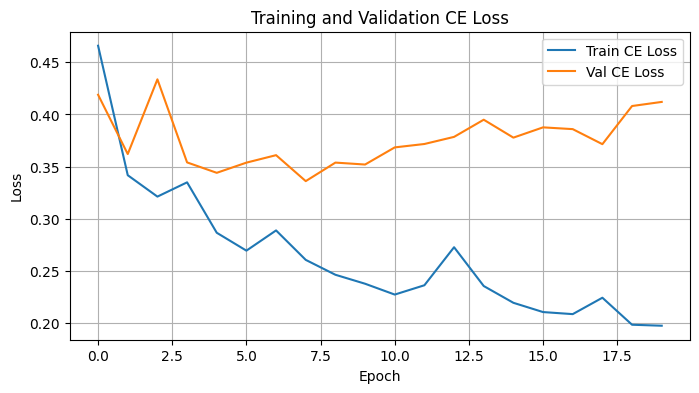

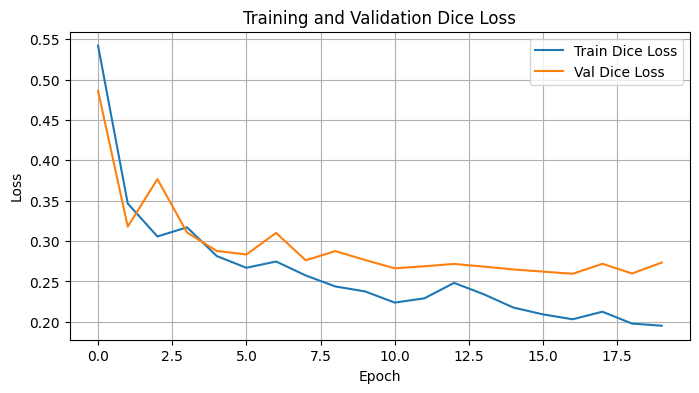

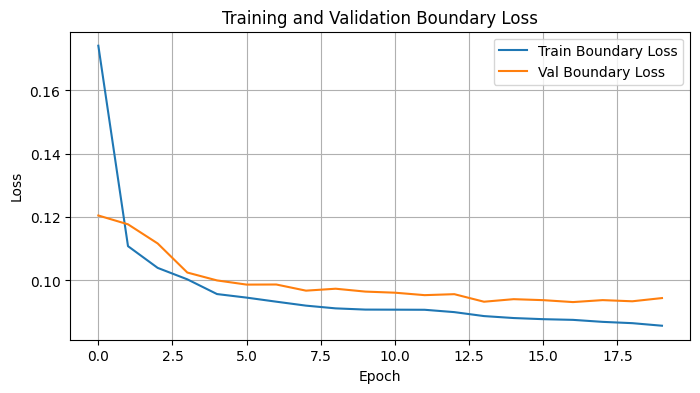

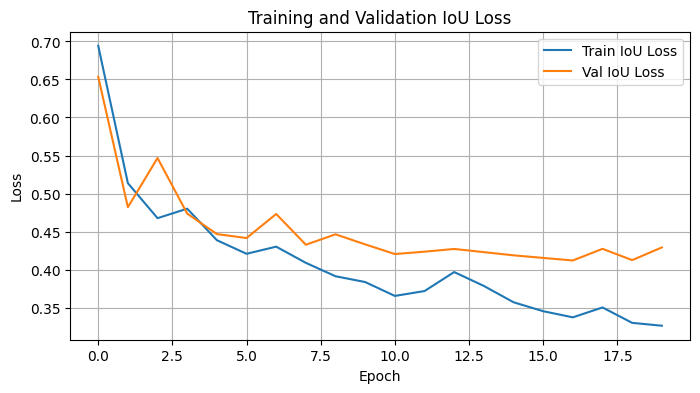

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation losses for CE Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_ce, label='Train CE Loss')
plt.plot(val_losses_ce, label='Val CE Loss')
plt.title('Training and Validation CE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for Dice Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_dice, label='Train Dice Loss')
plt.plot(val_losses_dice, label='Val Dice Loss')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for Boundary Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_boundary, label='Train Boundary Loss')
plt.plot(val_losses_boundary, label='Val Boundary Loss')
plt.title('Training and Validation Boundary Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for IoU Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_iou, label='Train IoU Loss')
plt.plot(val_losses_iou, label='Val IoU Loss')
plt.title('Training and Validation IoU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Printing the average IoU and Dice Score for train and validation dataset

mean_iou, mean_dice = evaluate_segmentation_model(model, train_dataloader)

mean_iou, mean_dice = evaluate_segmentation_model(model, val_dataloader)

print(f"Train Mean IoU: {mean_iou}, Train Mean Dice Score: {mean_dice}")
print(f"Validation Mean IoU: {mean_iou}, Validation Mean Dice Score: {mean_dice}")

100%|██████████| 6/6 [00:13<00:00,  2.17s/it]

Train Mean IoU: 0.528060100745768, Train Mean Dice Score: 0.6692140122711996
Validation Mean IoU: 0.528060100745768, Validation Mean Dice Score: 0.6692140122711996


In [ ]:
# Printing the average IoU and Dice Score for whole test dataset

mean_iou, mean_dice = evaluate_segmentation_model(model, test_dataloader)
print(f"Test Mean IoU: {mean_iou}, Test Mean Dice Score: {mean_dice}")

100%|██████████| 12/12 [00:25<00:00,  2.13s/it]

Test Mean IoU: 0.5175231548282001, Test Mean Dice Score: 0.6532527802552991


IoU:  0.778956228956229
Dice Score:  0.9023683692047154


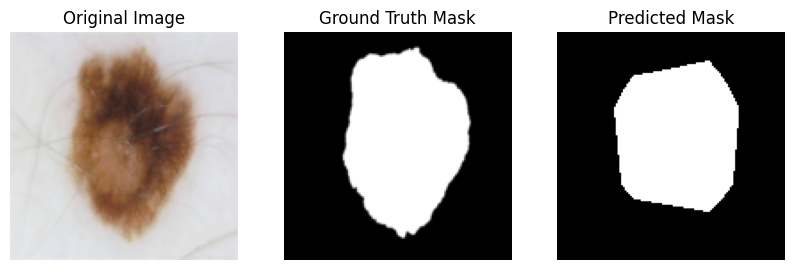

IoU:  0.0
Dice Score:  0.0


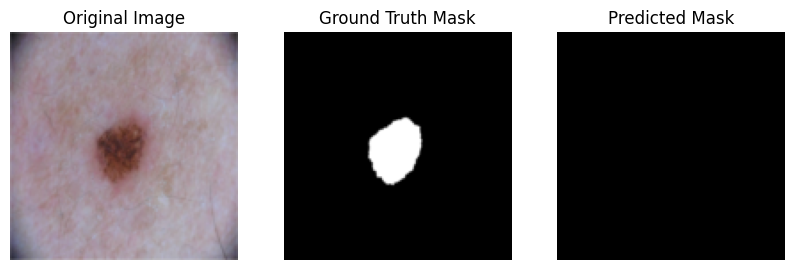

IoU:  0.717331499312242
Dice Score:  0.8654592242554697


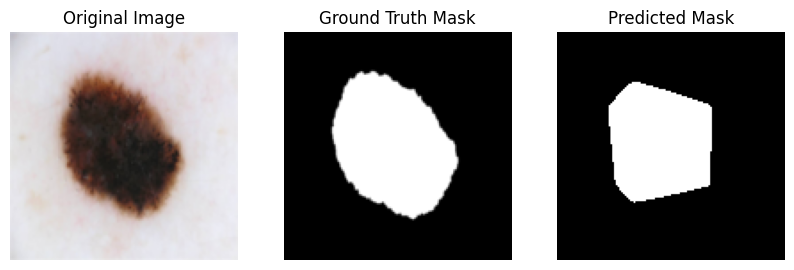

IoU:  0.6203993735317149
Dice Score:  0.795532737874893


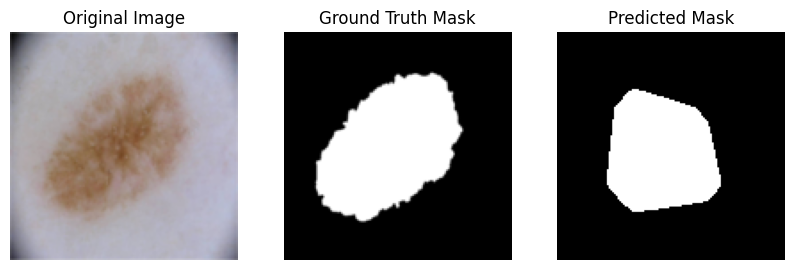

IoU:  0.7521435692921237
Dice Score:  0.8893384348562879


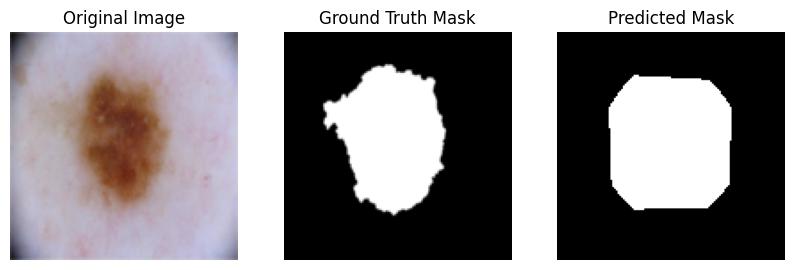

IoU:  0.6012884753042234
Dice Score:  0.7867407320487937


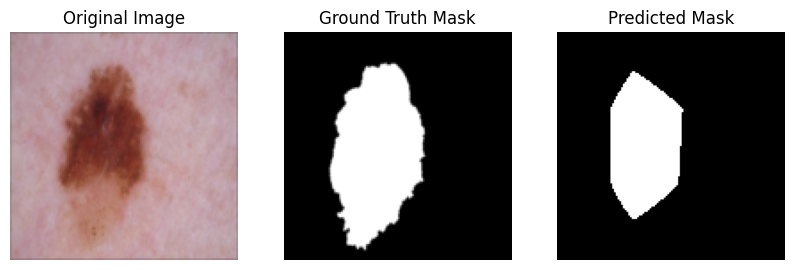

IoU:  0.6440875534257221
Dice Score:  0.8038475939593734


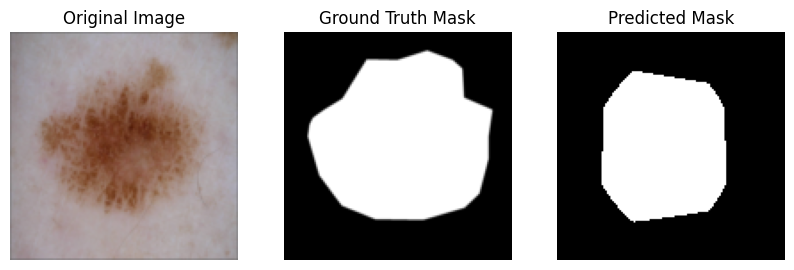

IoU:  0.6971971971971972
Dice Score:  0.8492719705827696


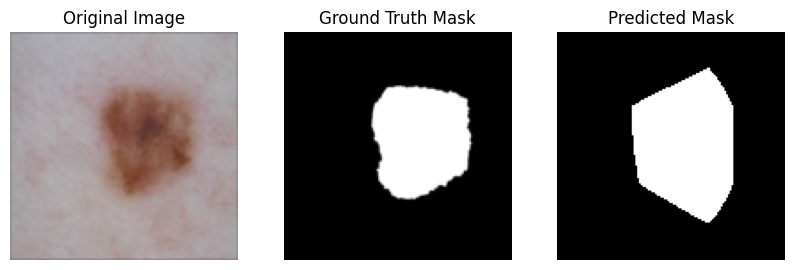

IoU:  0.6359420289855072
Dice Score:  0.8144432652683914


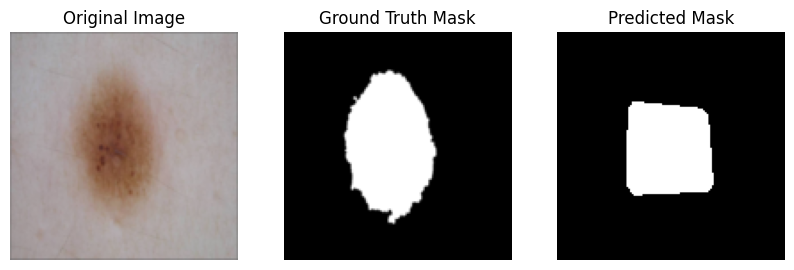

IoU:  0.8218961300532297
Dice Score:  0.9247012047282466


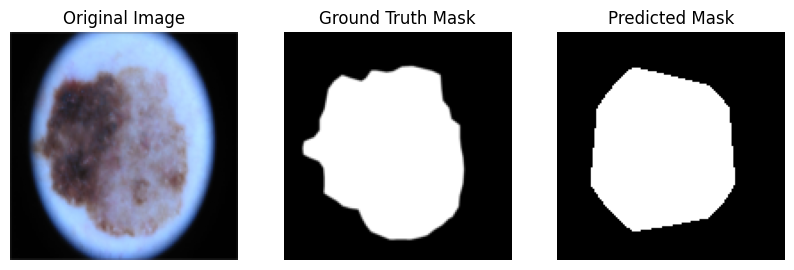

IoU:  0.7329622758194186
Dice Score:  0.8722593320433437


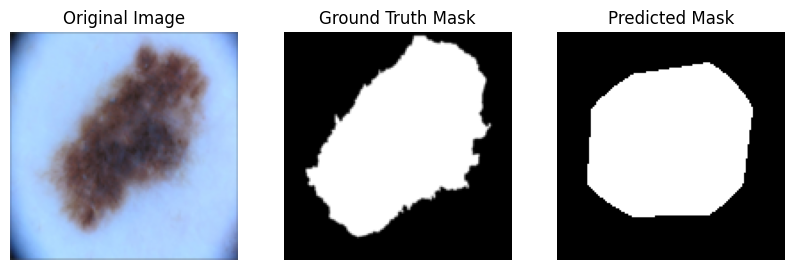

IoU:  0.37942551770207084
Dice Score:  0.5867727157627979


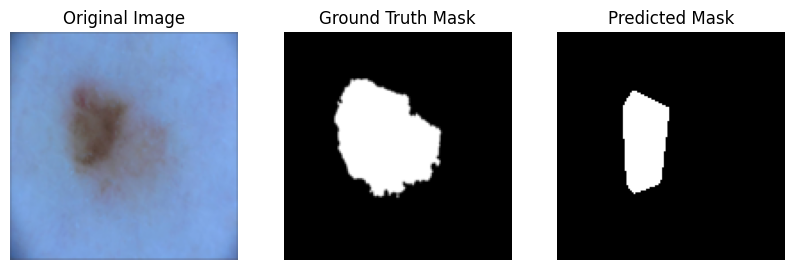

IoU:  0.6800991131977048
Dice Score:  0.8305338002742702


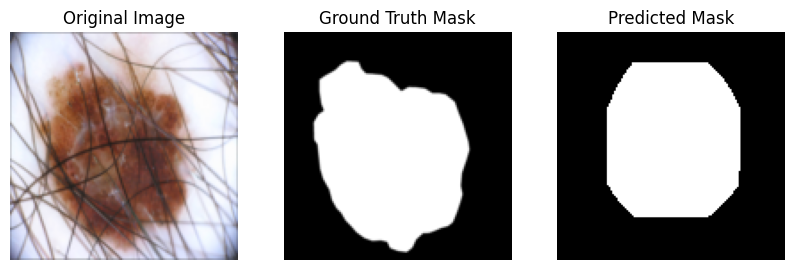

IoU:  0.6483285577841452
Dice Score:  0.8063154871374173


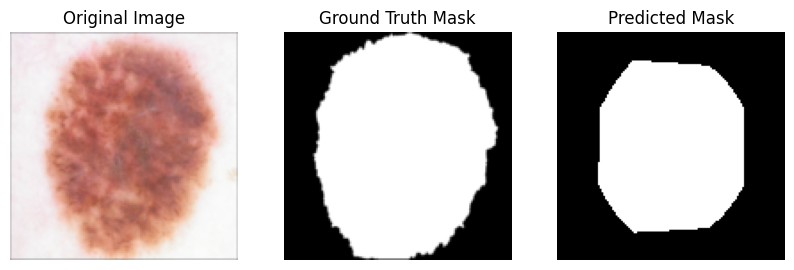

IoU:  0.8038793103448276
Dice Score:  0.9168603132599669


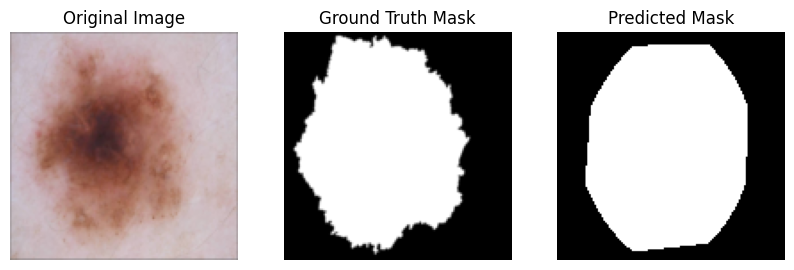

IoU:  0.7857652260733133
Dice Score:  0.908528523196405


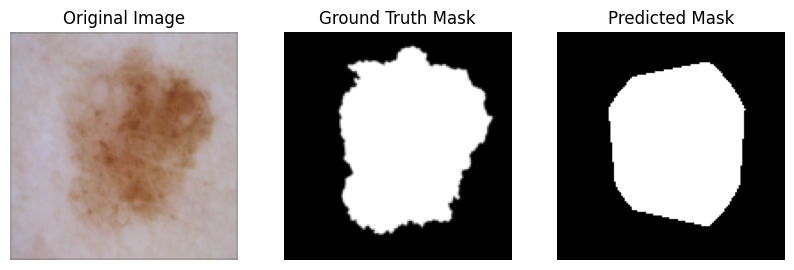

IoU:  0.6097218976396355
Dice Score:  0.7840707455553645


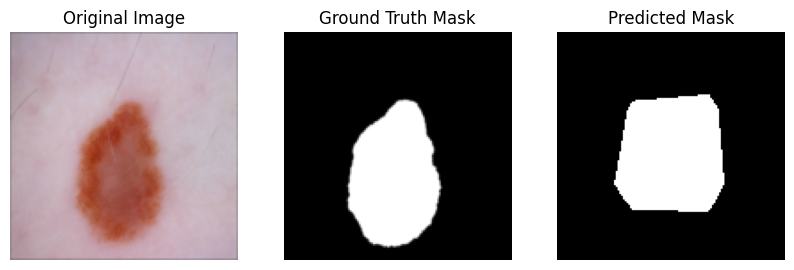

IoU:  0.5540819841543231
Dice Score:  0.7400979950092597


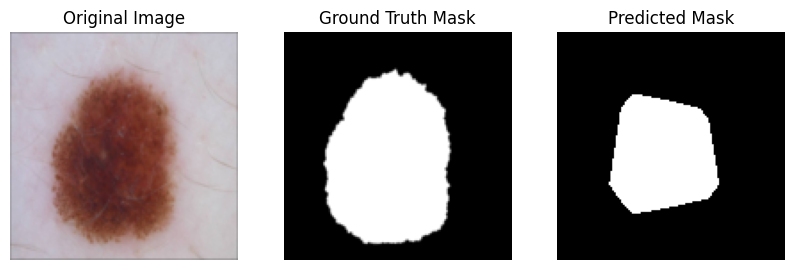

IoU:  0.6842286897503739
Dice Score:  0.8351335849942418


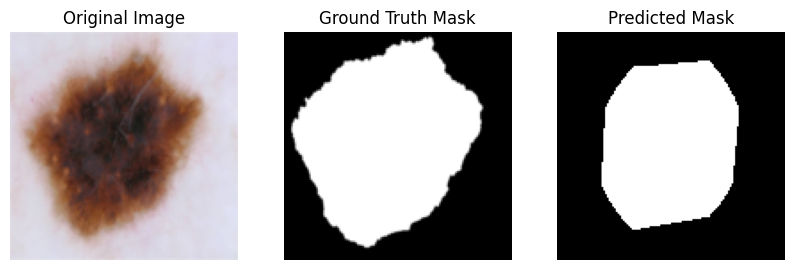

IoU:  0.6493975903614457
Dice Score:  0.8263243261148204


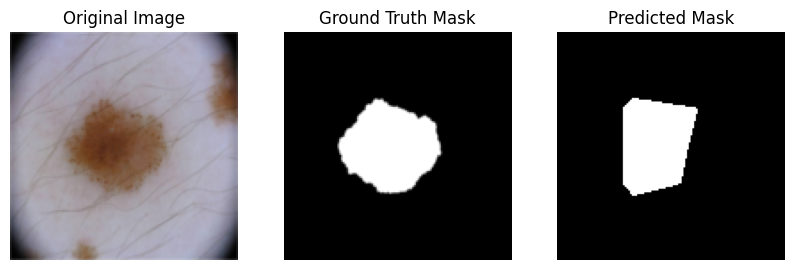

Average IoU: 0.6398566109442723
Average Dice Score: 0.7869300178063414


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model.eval()

# Initializing lists to store IoU and Dice Score values
iou_values = []
dice_scores = []

num_images_to_display = 20 # 20 images are displayed with its predicted and ground truth images

for images, gt_masks in (test_dataloader):
    images = images.to(device)
    # Pass test images through the model
    with torch.no_grad():
        outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

    # Calculating IoU and Dice Score for each pair of gt mask and predicted mask
    for image, gt_mask, predicted_mask in zip(images, gt_masks, predicted_masks):
        if num_images_to_display == 0:
            break

        image = image.permute(1, 2, 0).cpu().numpy()
        gt_mask = gt_mask.squeeze().cpu().numpy()
        predicted_mask = predicted_mask.cpu().numpy()

        # Calculating IoU
        intersection = np.logical_and(gt_mask, predicted_mask)
        union = np.logical_or(gt_mask, predicted_mask)
        iou = np.sum(intersection) / np.sum(union)
        print("IoU: ", iou)
        iou_values.append(iou)

        # Calculating Dice Score
        dice_score = 2 * np.sum(intersection) / (np.sum(gt_mask) + np.sum(predicted_mask))
        print("Dice Score: ", dice_score)
        dice_scores.append(dice_score)

        # Plot original image, gt mask, and predicted mask
        plt.figure(figsize=(10, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

        num_images_to_display -= 1

    if num_images_to_display == 0:
        break

# Calculate average IoU and Dice Score for given number of images
average_iou = np.mean(iou_values)
average_dice_score = np.mean(dice_scores)

# Printing the average IoU and Dice Score for given number of images
print("Average IoU:", average_iou)
print("Average Dice Score:", average_dice_score)


## Network 2

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.upconv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x, skip):
        x = self.relu(self.conv1(x))
        x = self.upconv(x)
        x = self.relu(self.conv2(x))
        x = self.upconv(x)
        x = self.relu(self.conv3(x))    
        # Adjusting the spatial dimensions of the skip connection tensor
        skip = nn.functional.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return x

class CustomSegmentationModel(nn.Module):
    def __init__(self, num_classes,fine_tune_encoder=False):
        super(CustomSegmentationModel, self).__init__()
        
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.encoder = mobilenet_v2.features

        # Freezing encoder weights if not fine-tuning
        if not fine_tune_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # Define decoder blocks
        self.decoder1 = DecoderBlock(1280, 736)
        self.decoder2 = DecoderBlock(2016, 352)
        self.decoder3 = DecoderBlock(512, 184)
        self.decoder4 = DecoderBlock(248, 128)

        # Final convolution for segmentation output
        self.last_conv = nn.Conv2d(160, num_classes, kernel_size=1)

    def forward(self, x):
        # Forward pass through the encoder
        features = []
        for name, layer in self.encoder._modules.items():
            x = layer(x)
            if name in ['4', '10', '14', '18']: 
                features.append(x)

        # Forward pass through the decoder
        x = self.decoder1(x, features[-1])
        x = self.decoder2(x, features[-2])
        x = self.decoder3(x, features[-3])
        x = self.decoder4(x, features[-4])
        x = self.last_conv(x)        
        # Upsample the output to match the size of the target masks
        x = nn.functional.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        
        return x
    
# Instantiating the model
num_classes = 2  # 2 classes considering foreground and background
model = CustomSegmentationModel(num_classes, fine_tune_encoder=False)

In [ ]:
import torch
from torchsummary import summary

# Assuming model is your PyTorch model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Assuming input_shape is the shape of your input data
input_shape = (3, 128, 128)

summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
             ReLU6-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]             288
       BatchNorm2d-5           [-1, 32, 64, 64]              64
             ReLU6-6           [-1, 32, 64, 64]               0
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
  InvertedResidual-9           [-1, 16, 64, 64]               0
           Conv2d-10           [-1, 96, 64, 64]           1,536
      BatchNorm2d-11           [-1, 96, 64, 64]             192
            ReLU6-12           [-1, 96, 64, 64]               0
           Conv2d-13           [-1, 96, 32, 32]             864
      BatchNorm2d-14           [-1, 96,

In [ ]:
import torch.nn.functional as F

model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Store losses for plotting
train_losses_ce=[]
train_losses_dice=[]
train_losses_boundary=[]
train_losses_iou=[]
val_losses_ce=[]
val_losses_dice=[]
val_losses_boundary=[]
val_losses_iou=[]
num_epochs = 20
# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_ce = 0.0
    train_loss_dice = 0.0
    train_loss_boundary = 0.0
    train_loss_iou = 0.0
    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        target_masks = masks.squeeze(1).long()
        ce_loss, dice, boundary, iou, total_loss_value = total_loss(outputs, target_masks, criterion)
        total_loss_value.backward()
        optimizer.step()
        train_loss_ce += ce_loss.item()
        train_loss_dice += dice.item()
        train_loss_boundary += boundary.item()
        train_loss_iou += iou.item()
    
    # Validation
    model.eval()
    val_loss_ce = 0.0
    val_loss_dice = 0.0
    val_loss_boundary = 0.0
    val_loss_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            target_masks = masks.squeeze(1).long()
            ce_loss, dice, boundary, iou, total_loss_value = total_loss(outputs, target_masks, criterion)
            val_loss_ce += ce_loss.item()
            val_loss_dice += dice.item()
            val_loss_boundary += boundary.item()
            val_loss_iou += iou.item()
    
    # Average losses
    train_loss_ce /= len(train_dataloader)
    train_loss_dice /= len(train_dataloader)
    train_loss_boundary /= len(train_dataloader)
    train_loss_iou /= len(train_dataloader)
    val_loss_ce /= len(val_dataloader)
    val_loss_dice /= len(val_dataloader)
    val_loss_boundary /= len(val_dataloader)
    val_loss_iou /= len(val_dataloader)

    # Print training and validation losses
    print(f'Epoch {epoch + 1}/{num_epochs}, Train CE Loss: {train_loss_ce:.4f}, Train Dice Loss: {train_loss_dice:.4f}, Train Boundary Loss: {train_loss_boundary:.4f}, Train IoU Loss: {train_loss_iou:.4f}, Val CE Loss: {val_loss_ce:.4f}, Val Dice Loss: {val_loss_dice:.4f}, Val Boundary Loss: {val_loss_boundary:.4f}, Val IoU Loss: {val_loss_iou:.4f}')
    
    # Store losses for plotting
    train_losses_ce.append(train_loss_ce)
    train_losses_dice.append(train_loss_dice)
    train_losses_boundary.append(train_loss_boundary)
    train_losses_iou.append(train_loss_iou)
    val_losses_ce.append(val_loss_ce)
    val_losses_dice.append(val_loss_dice)
    val_losses_boundary.append(val_loss_boundary)
    val_losses_iou.append(val_loss_iou)

100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 1/20, Train CE Loss: 0.6750, Train Dice Loss: 0.6906, Train Boundary Loss: 0.6199, Train IoU Loss: 0.8166, Val CE Loss: 0.5779, Val Dice Loss: 0.6890, Val Boundary Loss: 0.4252, Val IoU Loss: 0.8157


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 2/20, Train CE Loss: 0.4439, Train Dice Loss: 0.6438, Train Boundary Loss: 0.2600, Train IoU Loss: 0.7817, Val CE Loss: 0.4632, Val Dice Loss: 0.5486, Val Boundary Loss: 0.1886, Val IoU Loss: 0.7081


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 3/20, Train CE Loss: 0.3198, Train Dice Loss: 0.4777, Train Boundary Loss: 0.2081, Train IoU Loss: 0.6461, Val CE Loss: 0.3446, Val Dice Loss: 0.4464, Val Boundary Loss: 0.2443, Val IoU Loss: 0.6169


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 4/20, Train CE Loss: 0.2661, Train Dice Loss: 0.3662, Train Boundary Loss: 0.2365, Train IoU Loss: 0.5341, Val CE Loss: 0.2824, Val Dice Loss: 0.2926, Val Boundary Loss: 0.3442, Val IoU Loss: 0.4525


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 5/20, Train CE Loss: 0.2150, Train Dice Loss: 0.2110, Train Boundary Loss: 0.2789, Train IoU Loss: 0.3457, Val CE Loss: 0.2397, Val Dice Loss: 0.1795, Val Boundary Loss: 0.2068, Val IoU Loss: 0.3034


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 6/20, Train CE Loss: 0.1807, Train Dice Loss: 0.1501, Train Boundary Loss: 0.1178, Train IoU Loss: 0.2606, Val CE Loss: 0.2747, Val Dice Loss: 0.1736, Val Boundary Loss: 0.0916, Val IoU Loss: 0.2941


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 7/20, Train CE Loss: 0.1816, Train Dice Loss: 0.1434, Train Boundary Loss: 0.0820, Train IoU Loss: 0.2505, Val CE Loss: 0.2334, Val Dice Loss: 0.1564, Val Boundary Loss: 0.0794, Val IoU Loss: 0.2699


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 8/20, Train CE Loss: 0.1685, Train Dice Loss: 0.1368, Train Boundary Loss: 0.0743, Train IoU Loss: 0.2403, Val CE Loss: 0.2437, Val Dice Loss: 0.1481, Val Boundary Loss: 0.0769, Val IoU Loss: 0.2575


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 9/20, Train CE Loss: 0.1512, Train Dice Loss: 0.1209, Train Boundary Loss: 0.0712, Train IoU Loss: 0.2155, Val CE Loss: 0.2756, Val Dice Loss: 0.1554, Val Boundary Loss: 0.0789, Val IoU Loss: 0.2673


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 10/20, Train CE Loss: 0.1518, Train Dice Loss: 0.1229, Train Boundary Loss: 0.0706, Train IoU Loss: 0.2184, Val CE Loss: 0.2682, Val Dice Loss: 0.1502, Val Boundary Loss: 0.0779, Val IoU Loss: 0.2602


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 11/20, Train CE Loss: 0.1467, Train Dice Loss: 0.1152, Train Boundary Loss: 0.0700, Train IoU Loss: 0.2063, Val CE Loss: 0.2392, Val Dice Loss: 0.1412, Val Boundary Loss: 0.0755, Val IoU Loss: 0.2467


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 12/20, Train CE Loss: 0.1377, Train Dice Loss: 0.1092, Train Boundary Loss: 0.0681, Train IoU Loss: 0.1966, Val CE Loss: 0.2471, Val Dice Loss: 0.1421, Val Boundary Loss: 0.0757, Val IoU Loss: 0.2480


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 13/20, Train CE Loss: 0.1312, Train Dice Loss: 0.1045, Train Boundary Loss: 0.0671, Train IoU Loss: 0.1890, Val CE Loss: 0.2621, Val Dice Loss: 0.1418, Val Boundary Loss: 0.0757, Val IoU Loss: 0.2476


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 14/20, Train CE Loss: 0.1289, Train Dice Loss: 0.1010, Train Boundary Loss: 0.0668, Train IoU Loss: 0.1833, Val CE Loss: 0.2748, Val Dice Loss: 0.1414, Val Boundary Loss: 0.0754, Val IoU Loss: 0.2467


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 15/20, Train CE Loss: 0.1185, Train Dice Loss: 0.0948, Train Boundary Loss: 0.0652, Train IoU Loss: 0.1730, Val CE Loss: 0.3099, Val Dice Loss: 0.1463, Val Boundary Loss: 0.0764, Val IoU Loss: 0.2540


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 16/20, Train CE Loss: 0.1234, Train Dice Loss: 0.0979, Train Boundary Loss: 0.0660, Train IoU Loss: 0.1780, Val CE Loss: 0.2930, Val Dice Loss: 0.1415, Val Boundary Loss: 0.0752, Val IoU Loss: 0.2465


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 17/20, Train CE Loss: 0.1183, Train Dice Loss: 0.0908, Train Boundary Loss: 0.0650, Train IoU Loss: 0.1663, Val CE Loss: 0.2843, Val Dice Loss: 0.1417, Val Boundary Loss: 0.0771, Val IoU Loss: 0.2478


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 18/20, Train CE Loss: 0.1138, Train Dice Loss: 0.0895, Train Boundary Loss: 0.0643, Train IoU Loss: 0.1642, Val CE Loss: 0.2833, Val Dice Loss: 0.1384, Val Boundary Loss: 0.0766, Val IoU Loss: 0.2427


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 19/20, Train CE Loss: 0.1156, Train Dice Loss: 0.0928, Train Boundary Loss: 0.0645, Train IoU Loss: 0.1695, Val CE Loss: 0.2929, Val Dice Loss: 0.1379, Val Boundary Loss: 0.0754, Val IoU Loss: 0.2415


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]

Epoch 20/20, Train CE Loss: 0.1107, Train Dice Loss: 0.0877, Train Boundary Loss: 0.0635, Train IoU Loss: 0.1612, Val CE Loss: 0.3062, Val Dice Loss: 0.1461, Val Boundary Loss: 0.0755, Val IoU Loss: 0.2536


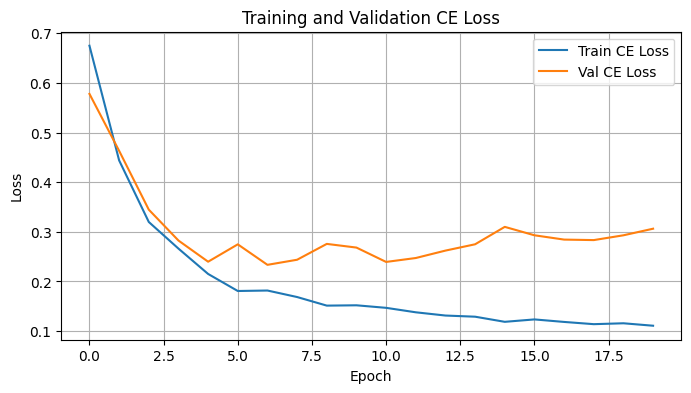

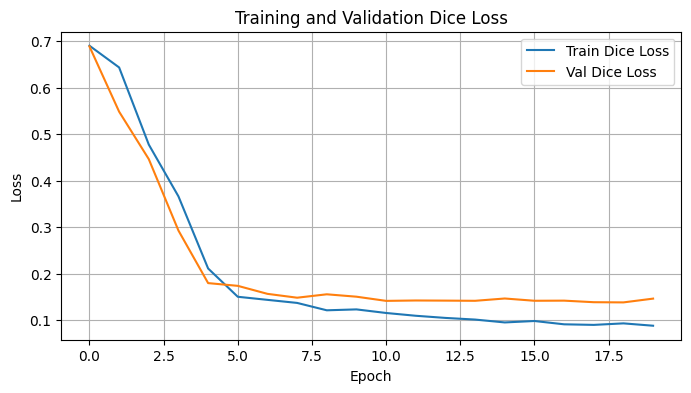

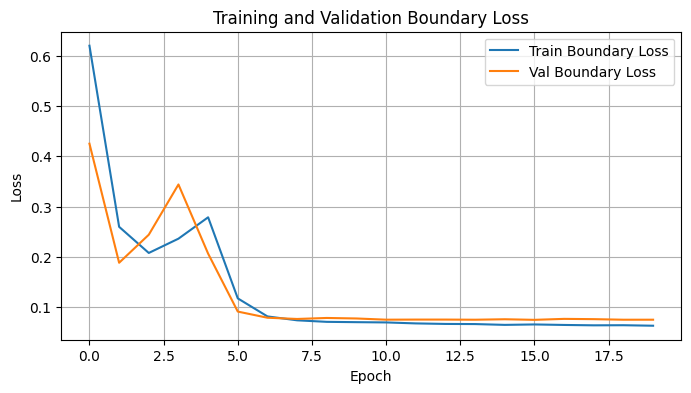

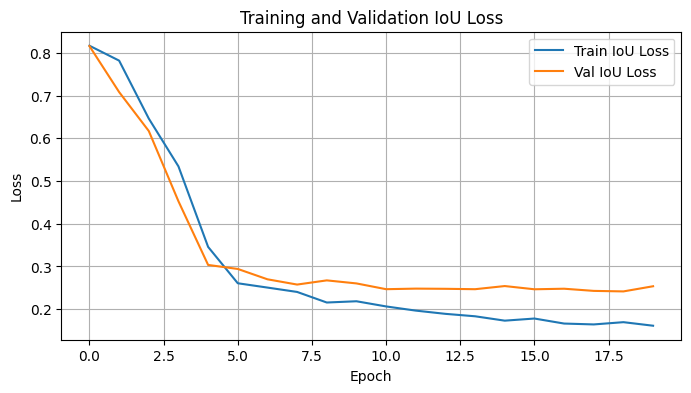

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation losses for CE Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_ce, label='Train CE Loss')
plt.plot(val_losses_ce, label='Val CE Loss')
plt.title('Training and Validation CE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for Dice Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_dice, label='Train Dice Loss')
plt.plot(val_losses_dice, label='Val Dice Loss')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for Boundary Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_boundary, label='Train Boundary Loss')
plt.plot(val_losses_boundary, label='Val Boundary Loss')
plt.title('Training and Validation Boundary Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for IoU Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_iou, label='Train IoU Loss')
plt.plot(val_losses_iou, label='Val IoU Loss')
plt.title('Training and Validation IoU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Printing the average IoU and Dice Score for train and validation dataset

mean_iou, mean_dice = evaluate_segmentation_model(model, train_dataloader)

mean_iou, mean_dice = evaluate_segmentation_model(model, val_dataloader)

print(f"Train Mean IoU: {mean_iou}, Train Mean Dice Score: {mean_dice}")
print(f"Validation Mean IoU: {mean_iou}, Validation Mean Dice Score: {mean_dice}")

100%|██████████| 6/6 [00:12<00:00,  2.12s/it]

Train Mean IoU: 0.7563152582682556, Train Mean Dice Score: 0.8844469605314804
Validation Mean IoU: 0.7563152582682556, Validation Mean Dice Score: 0.8844469605314804


In [ ]:
# Printing the average IoU and Dice Score for whole test dataset

mean_iou, mean_dice = evaluate_segmentation_model(model, test_dataloader)
print(f"Test Mean IoU: {mean_iou}, Test Mean Dice Score: {mean_dice}")

100%|██████████| 12/12 [00:25<00:00,  2.12s/it]

Test Mean IoU: 0.7429749110394606, Test Mean Dice Score: 0.8723494743525597


IoU:  0.8975820379965458
Dice Score:  0.9736553488236364


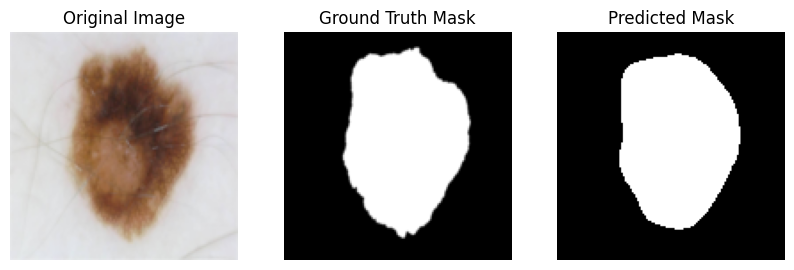

IoU:  0.8019891500904159
Dice Score:  0.9456942258321201


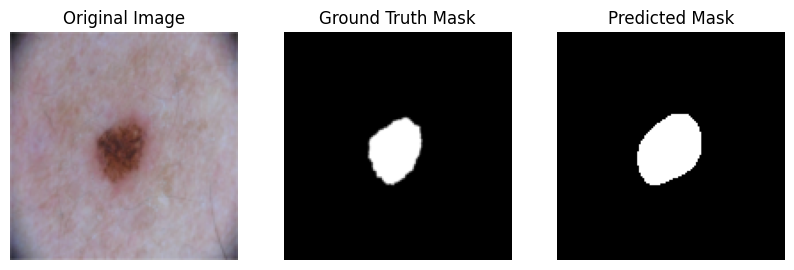

IoU:  0.8734939759036144
Dice Score:  0.9634744458636179


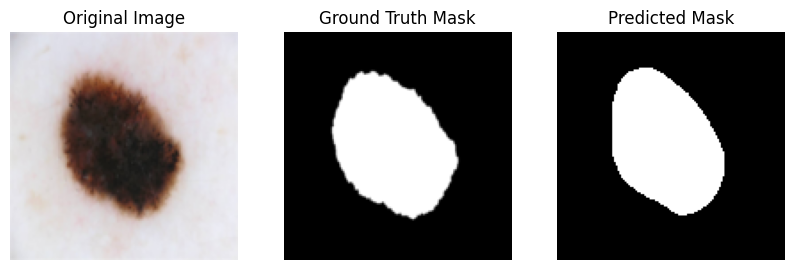

IoU:  0.8060930424042816
Dice Score:  0.9253320940141159


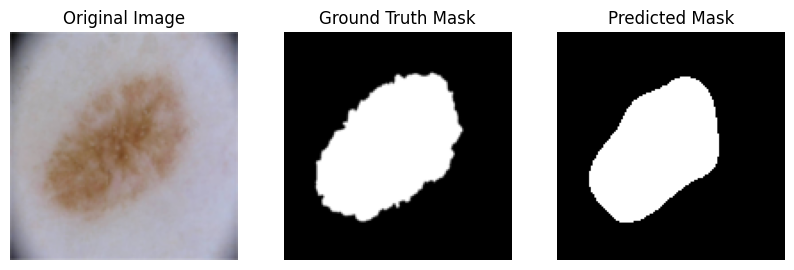

IoU:  0.8438546150167384
Dice Score:  0.9529197224170282


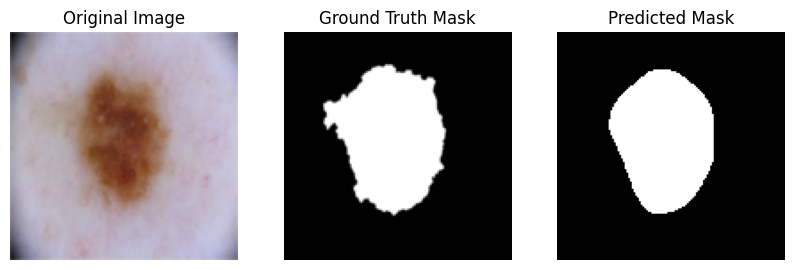

IoU:  0.7709978463747308
Dice Score:  0.9080946602137987


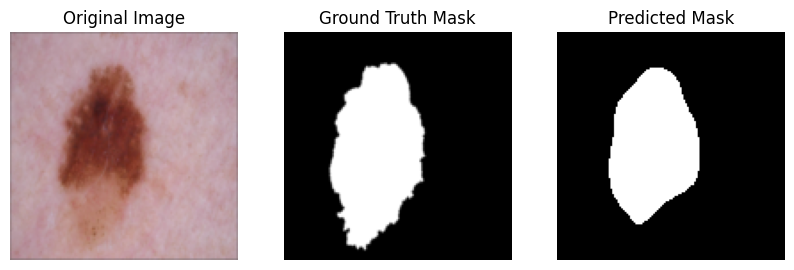

IoU:  0.7374592833876221
Dice Score:  0.8698330102635925


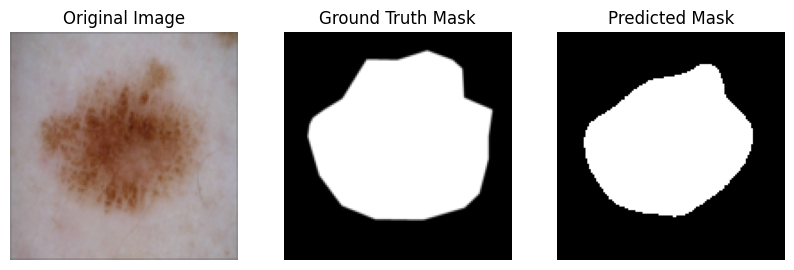

IoU:  0.9094022415940224
Dice Score:  0.988174121062318


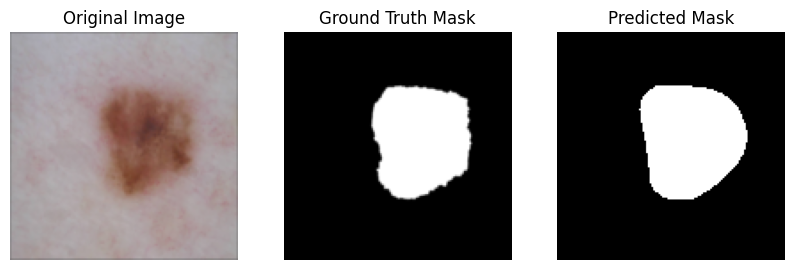

IoU:  0.7402714932126697
Dice Score:  0.8903030716372884


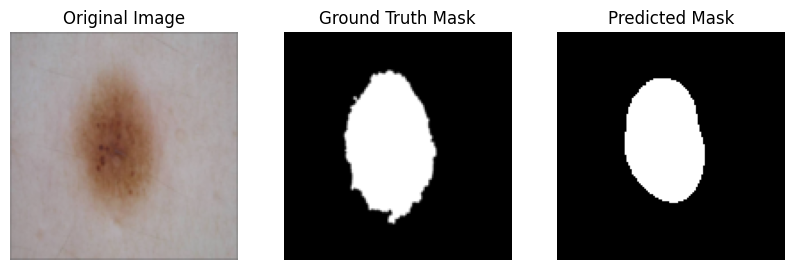

IoU:  0.8096992924528302
Dice Score:  0.9178386660672662


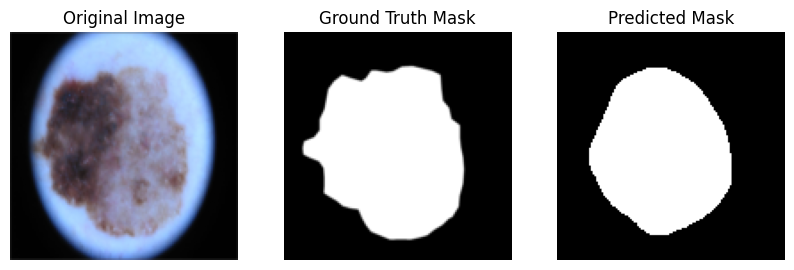

IoU:  0.7940858763165002
Dice Score:  0.9143557480012611


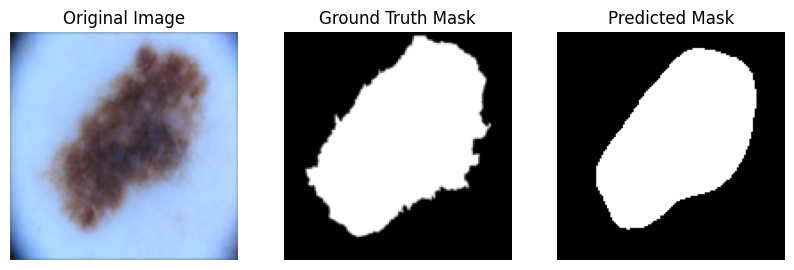

IoU:  0.6010836437521165
Dice Score:  0.7941785870647114


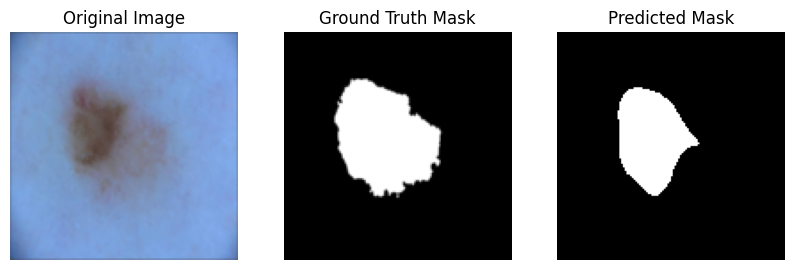

IoU:  0.8511731223101485
Dice Score:  0.9425645590492717


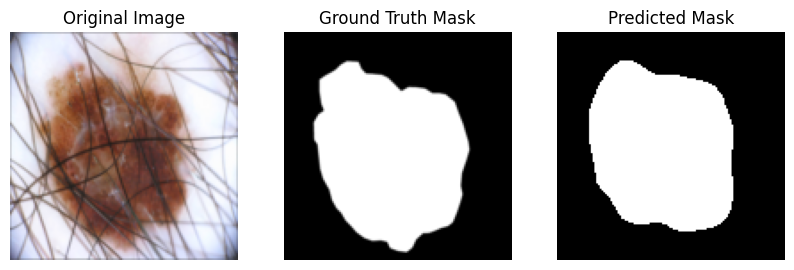

IoU:  0.9086948285660162
Dice Score:  0.9724758109874628


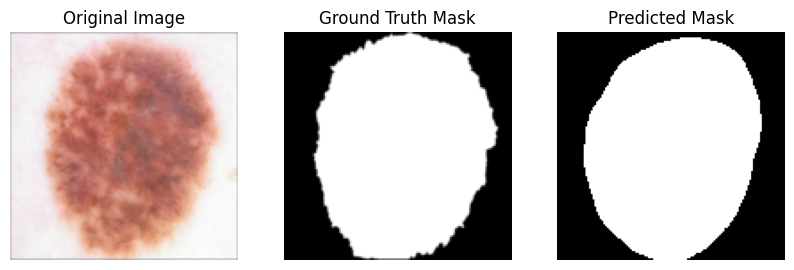

IoU:  0.8762898036169977
Dice Score:  0.961964037822696


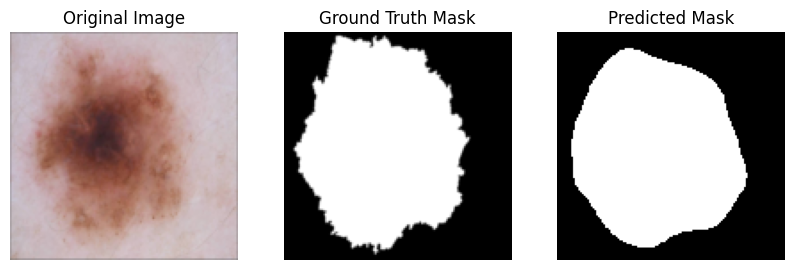

IoU:  0.831903446270176
Dice Score:  0.9374614220358172


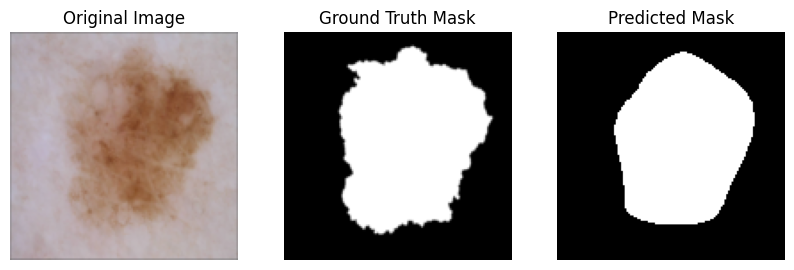

IoU:  0.8630764823832713
Dice Score:  0.9609294752204931


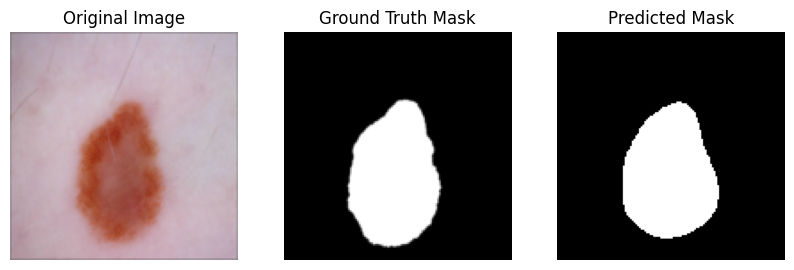

IoU:  0.9189003436426116
Dice Score:  0.9868575814208791


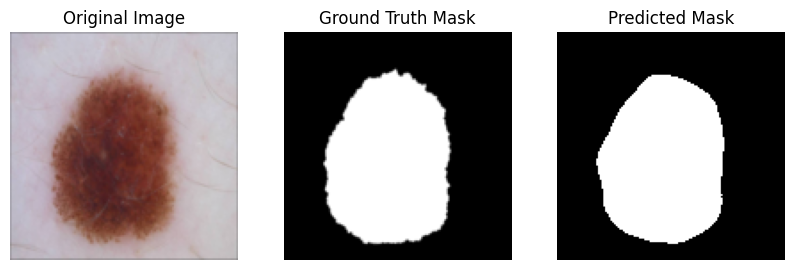

IoU:  0.820855614973262
Dice Score:  0.9250363114222115


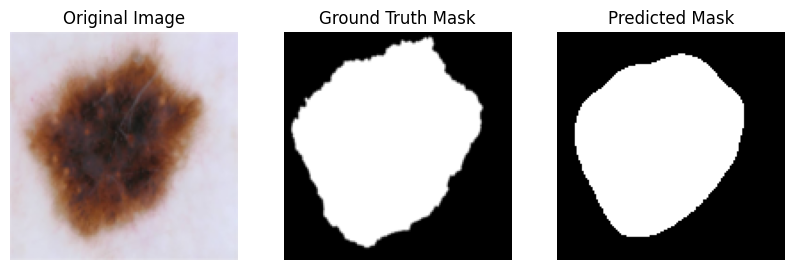

IoU:  0.8847472150814053
Dice Score:  0.9819965252612831


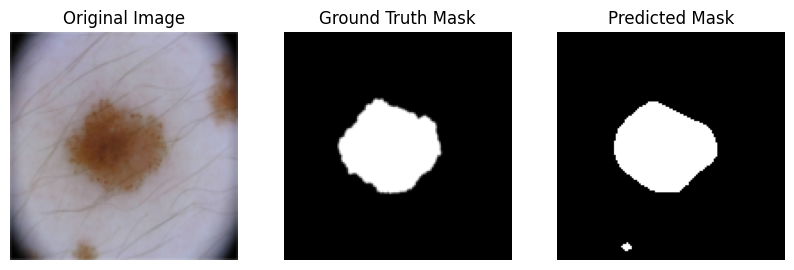

Average IoU: 0.8270826677672988
Average Dice Score: 0.9356569712240435


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model.eval()

# Initializing lists to store IoU and Dice Score values
iou_values = []
dice_scores = []

num_images_to_display = 20 # 20 images are displayed with its predicted and ground truth images

for images, gt_masks in (test_dataloader):
    images = images.to(device)
    # Pass test images through the model
    with torch.no_grad():
        outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

    # Calculating IoU and Dice Score for each pair of gt mask and predicted mask
    for image, gt_mask, predicted_mask in zip(images, gt_masks, predicted_masks):
        if num_images_to_display == 0:
            break

        image = image.permute(1, 2, 0).cpu().numpy()
        gt_mask = gt_mask.squeeze().cpu().numpy()
        predicted_mask = predicted_mask.cpu().numpy()

        # Calculating IoU
        intersection = np.logical_and(gt_mask, predicted_mask)
        union = np.logical_or(gt_mask, predicted_mask)
        iou = np.sum(intersection) / np.sum(union)
        print("IoU: ", iou)
        iou_values.append(iou)

        # Calculating Dice Score
        dice_score = 2 * np.sum(intersection) / (np.sum(gt_mask) + np.sum(predicted_mask))
        print("Dice Score: ", dice_score)
        dice_scores.append(dice_score)

        # Plot original image, gt mask, and predicted mask
        plt.figure(figsize=(10, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

        num_images_to_display -= 1

    if num_images_to_display == 0:
        break

# Calculate average IoU and Dice Score for given number of images
average_iou = np.mean(iou_values)
average_dice_score = np.mean(dice_scores)

# Printing the average IoU and Dice Score for given number of images
print("Average IoU:", average_iou)
print("Average Dice Score:", average_dice_score)


## Fine Tuning Network 1

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

class CustomSegmentationModel(nn.Module):
    def __init__(self, num_classes, fine_tune_encoder=False):
        super(CustomSegmentationModel, self).__init__()
        # Loading pre-trained MobileNetV2 model
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.encoder = mobilenet_v2.features

        # Freeze encoder weights if not fine-tuning
        if not fine_tune_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # Define custom decoder
        self.conv1 = nn.Conv2d(1280, 256, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.upsample = nn.Upsample(size=(128, 128), mode='bilinear', align_corners=True)

    def forward(self, x):
        # Forward pass through the encoder
        x = self.encoder(x)
        # Forward pass through the decoder
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.upsample(x)
        return x

# Instantiating the model
num_classes = 2  # 2 classes considering foreground and background
model = CustomSegmentationModel(num_classes, fine_tune_encoder=True)


In [ ]:
import torch.nn.functional as F

model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Store losses for plotting
train_losses_ce=[]
train_losses_dice=[]
train_losses_boundary=[]
train_losses_iou=[]
val_losses_ce=[]
val_losses_dice=[]
val_losses_boundary=[]
val_losses_iou=[]
num_epochs = 20
# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_ce = 0.0
    train_loss_dice = 0.0
    train_loss_boundary = 0.0
    train_loss_iou = 0.0
    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        target_masks = masks.squeeze(1).long()
        ce_loss, dice, boundary, iou, total_loss_value = total_loss(outputs, target_masks, criterion)
        total_loss_value.backward()
        optimizer.step()
        train_loss_ce += ce_loss.item()
        train_loss_dice += dice.item()
        train_loss_boundary += boundary.item()
        train_loss_iou += iou.item()
    
    # Validation
    model.eval()
    val_loss_ce = 0.0
    val_loss_dice = 0.0
    val_loss_boundary = 0.0
    val_loss_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            target_masks = masks.squeeze(1).long()
            ce_loss, dice, boundary, iou, total_loss_value = total_loss(outputs, target_masks, criterion)
            val_loss_ce += ce_loss.item()
            val_loss_dice += dice.item()
            val_loss_boundary += boundary.item()
            val_loss_iou += iou.item()
    
    # Average losses
    train_loss_ce /= len(train_dataloader)
    train_loss_dice /= len(train_dataloader)
    train_loss_boundary /= len(train_dataloader)
    train_loss_iou /= len(train_dataloader)
    val_loss_ce /= len(val_dataloader)
    val_loss_dice /= len(val_dataloader)
    val_loss_boundary /= len(val_dataloader)
    val_loss_iou /= len(val_dataloader)

    # Print training and validation losses
    print(f'Epoch {epoch + 1}/{num_epochs}, Train CE Loss: {train_loss_ce:.4f}, Train Dice Loss: {train_loss_dice:.4f}, Train Boundary Loss: {train_loss_boundary:.4f}, Train IoU Loss: {train_loss_iou:.4f}, Val CE Loss: {val_loss_ce:.4f}, Val Dice Loss: {val_loss_dice:.4f}, Val Boundary Loss: {val_loss_boundary:.4f}, Val IoU Loss: {val_loss_iou:.4f}')
    
    # Store losses for plotting
    train_losses_ce.append(train_loss_ce)
    train_losses_dice.append(train_loss_dice)
    train_losses_boundary.append(train_loss_boundary)
    train_losses_iou.append(train_loss_iou)
    val_losses_ce.append(val_loss_ce)
    val_losses_dice.append(val_loss_dice)
    val_losses_boundary.append(val_loss_boundary)
    val_losses_iou.append(val_loss_iou)

100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 1/20, Train CE Loss: 0.4094, Train Dice Loss: 0.4754, Train Boundary Loss: 0.1982, Train IoU Loss: 0.6295, Val CE Loss: 0.3393, Val Dice Loss: 0.3571, Val Boundary Loss: 0.1499, Val IoU Loss: 0.5258


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 2/20, Train CE Loss: 0.2786, Train Dice Loss: 0.2523, Train Boundary Loss: 0.1168, Train IoU Loss: 0.4018, Val CE Loss: 0.2604, Val Dice Loss: 0.2230, Val Boundary Loss: 0.1016, Val IoU Loss: 0.3646


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 3/20, Train CE Loss: 0.2197, Train Dice Loss: 0.2107, Train Boundary Loss: 0.0916, Train IoU Loss: 0.3476, Val CE Loss: 0.2630, Val Dice Loss: 0.2099, Val Boundary Loss: 0.0972, Val IoU Loss: 0.3468


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 4/20, Train CE Loss: 0.1997, Train Dice Loss: 0.1906, Train Boundary Loss: 0.0882, Train IoU Loss: 0.3198, Val CE Loss: 0.2290, Val Dice Loss: 0.1895, Val Boundary Loss: 0.0919, Val IoU Loss: 0.3185


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 5/20, Train CE Loss: 0.1924, Train Dice Loss: 0.1820, Train Boundary Loss: 0.0861, Train IoU Loss: 0.3074, Val CE Loss: 0.2206, Val Dice Loss: 0.1818, Val Boundary Loss: 0.0897, Val IoU Loss: 0.3076


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 6/20, Train CE Loss: 0.1695, Train Dice Loss: 0.1666, Train Boundary Loss: 0.0856, Train IoU Loss: 0.2854, Val CE Loss: 0.2223, Val Dice Loss: 0.1730, Val Boundary Loss: 0.0891, Val IoU Loss: 0.2948


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 7/20, Train CE Loss: 0.1642, Train Dice Loss: 0.1593, Train Boundary Loss: 0.0838, Train IoU Loss: 0.2743, Val CE Loss: 0.2292, Val Dice Loss: 0.1749, Val Boundary Loss: 0.0893, Val IoU Loss: 0.2975


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 8/20, Train CE Loss: 0.1495, Train Dice Loss: 0.1472, Train Boundary Loss: 0.0836, Train IoU Loss: 0.2563, Val CE Loss: 0.2263, Val Dice Loss: 0.1668, Val Boundary Loss: 0.0880, Val IoU Loss: 0.2857


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 9/20, Train CE Loss: 0.1539, Train Dice Loss: 0.1467, Train Boundary Loss: 0.0830, Train IoU Loss: 0.2553, Val CE Loss: 0.2236, Val Dice Loss: 0.1649, Val Boundary Loss: 0.0881, Val IoU Loss: 0.2829


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 10/20, Train CE Loss: 0.1353, Train Dice Loss: 0.1322, Train Boundary Loss: 0.0821, Train IoU Loss: 0.2334, Val CE Loss: 0.2233, Val Dice Loss: 0.1557, Val Boundary Loss: 0.0865, Val IoU Loss: 0.2693


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 11/20, Train CE Loss: 0.1458, Train Dice Loss: 0.1352, Train Boundary Loss: 0.0814, Train IoU Loss: 0.2378, Val CE Loss: 0.2406, Val Dice Loss: 0.1654, Val Boundary Loss: 0.0871, Val IoU Loss: 0.2836


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 12/20, Train CE Loss: 0.1395, Train Dice Loss: 0.1298, Train Boundary Loss: 0.0811, Train IoU Loss: 0.2296, Val CE Loss: 0.2185, Val Dice Loss: 0.1526, Val Boundary Loss: 0.0845, Val IoU Loss: 0.2647


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 13/20, Train CE Loss: 0.1302, Train Dice Loss: 0.1236, Train Boundary Loss: 0.0799, Train IoU Loss: 0.2198, Val CE Loss: 0.2415, Val Dice Loss: 0.1558, Val Boundary Loss: 0.0852, Val IoU Loss: 0.2694


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 14/20, Train CE Loss: 0.1344, Train Dice Loss: 0.1242, Train Boundary Loss: 0.0802, Train IoU Loss: 0.2207, Val CE Loss: 0.2376, Val Dice Loss: 0.1475, Val Boundary Loss: 0.0842, Val IoU Loss: 0.2570


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 15/20, Train CE Loss: 0.1372, Train Dice Loss: 0.1241, Train Boundary Loss: 0.0797, Train IoU Loss: 0.2205, Val CE Loss: 0.2575, Val Dice Loss: 0.1515, Val Boundary Loss: 0.0852, Val IoU Loss: 0.2631


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 16/20, Train CE Loss: 0.1489, Train Dice Loss: 0.1287, Train Boundary Loss: 0.0808, Train IoU Loss: 0.2277, Val CE Loss: 0.2677, Val Dice Loss: 0.1546, Val Boundary Loss: 0.0850, Val IoU Loss: 0.2678


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 17/20, Train CE Loss: 0.1450, Train Dice Loss: 0.1284, Train Boundary Loss: 0.0802, Train IoU Loss: 0.2267, Val CE Loss: 0.2224, Val Dice Loss: 0.1451, Val Boundary Loss: 0.0846, Val IoU Loss: 0.2534


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 18/20, Train CE Loss: 0.1291, Train Dice Loss: 0.1199, Train Boundary Loss: 0.0793, Train IoU Loss: 0.2139, Val CE Loss: 0.2185, Val Dice Loss: 0.1444, Val Boundary Loss: 0.0847, Val IoU Loss: 0.2523


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 19/20, Train CE Loss: 0.1269, Train Dice Loss: 0.1162, Train Boundary Loss: 0.0791, Train IoU Loss: 0.2078, Val CE Loss: 0.2579, Val Dice Loss: 0.1602, Val Boundary Loss: 0.0842, Val IoU Loss: 0.2760


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]

Epoch 20/20, Train CE Loss: 0.1286, Train Dice Loss: 0.1148, Train Boundary Loss: 0.0800, Train IoU Loss: 0.2057, Val CE Loss: 0.2315, Val Dice Loss: 0.1424, Val Boundary Loss: 0.0845, Val IoU Loss: 0.2491


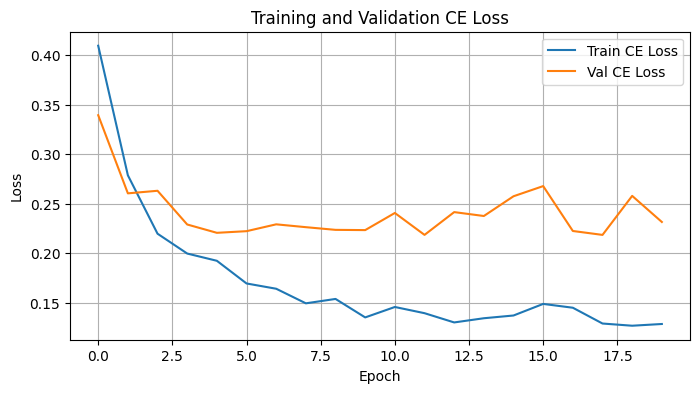

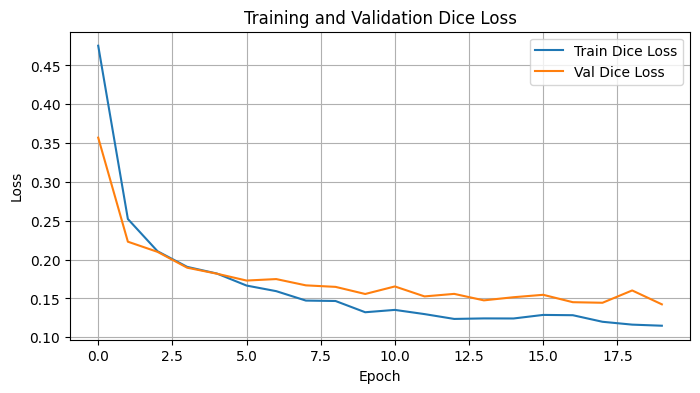

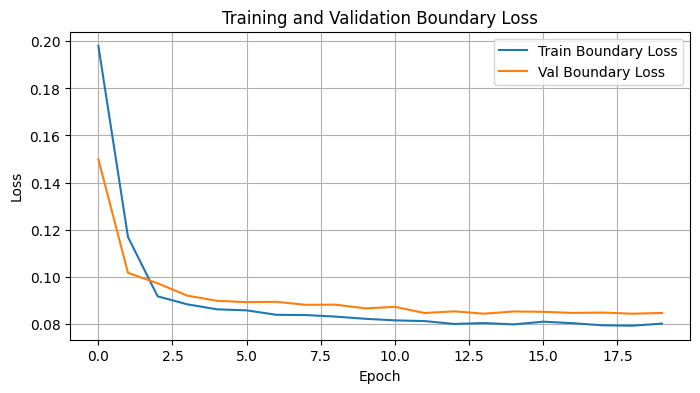

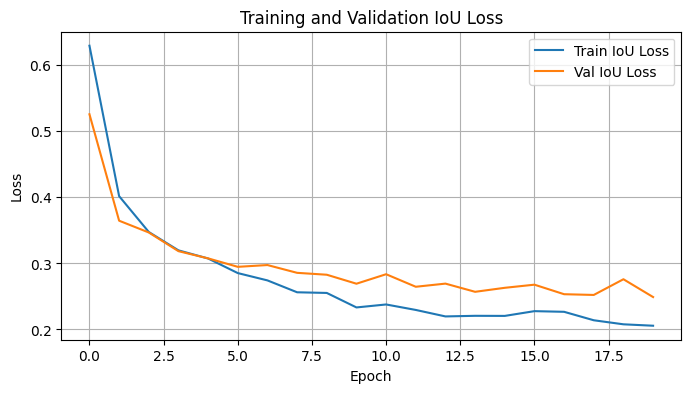

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation losses for CE Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_ce, label='Train CE Loss')
plt.plot(val_losses_ce, label='Val CE Loss')
plt.title('Training and Validation CE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for Dice Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_dice, label='Train Dice Loss')
plt.plot(val_losses_dice, label='Val Dice Loss')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for Boundary Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_boundary, label='Train Boundary Loss')
plt.plot(val_losses_boundary, label='Val Boundary Loss')
plt.title('Training and Validation Boundary Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for IoU Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_iou, label='Train IoU Loss')
plt.plot(val_losses_iou, label='Val IoU Loss')
plt.title('Training and Validation IoU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Printing the average IoU and Dice Score for train and validation dataset

mean_iou, mean_dice = evaluate_segmentation_model(model, train_dataloader)

mean_iou, mean_dice = evaluate_segmentation_model(model, val_dataloader)

print(f"Train Mean IoU: {mean_iou}, Train Mean Dice Score: {mean_dice}")
print(f"Validation Mean IoU: {mean_iou}, Validation Mean Dice Score: {mean_dice}")

100%|██████████| 6/6 [00:12<00:00,  2.10s/it]

Train Mean IoU: 0.7137149643258363, Train Mean Dice Score: 0.8515174076305666
Validation Mean IoU: 0.7137149643258363, Validation Mean Dice Score: 0.8515174076305666


In [ ]:
# Printing the average IoU and Dice Score for whole test dataset

mean_iou, mean_dice = evaluate_segmentation_model(model, test_dataloader)
print(f"Test Mean IoU: {mean_iou}, Test Mean Dice Score: {mean_dice}")

100%|██████████| 12/12 [00:24<00:00,  2.08s/it]

Test Mean IoU: 0.6849738424245867, Test Mean Dice Score: 0.8202935220346881


IoU:  0.8307972213033411
Dice Score:  0.9338830723398468


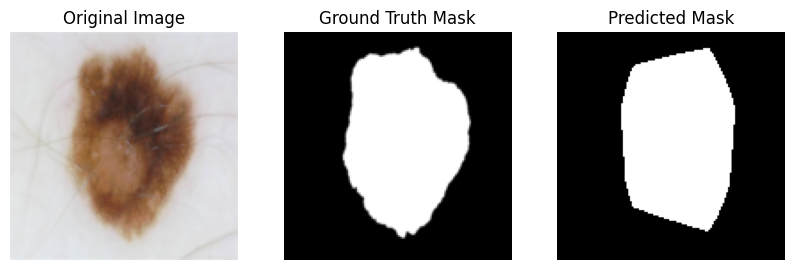

IoU:  0.4887599709934735
Dice Score:  0.6963275314951107


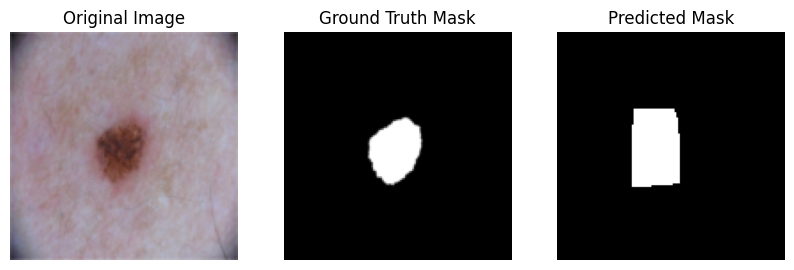

IoU:  0.8672161172161172
Dice Score:  0.9594921972084427


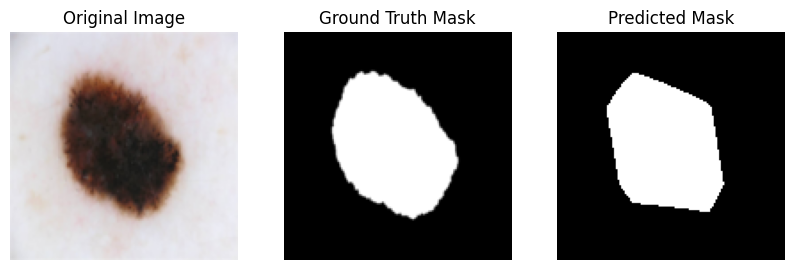

IoU:  0.868151715833835
Dice Score:  0.9614414120337312


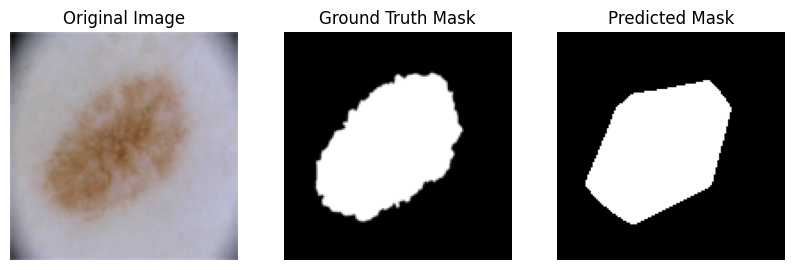

IoU:  0.7212106881059352
Dice Score:  0.8745883390368355


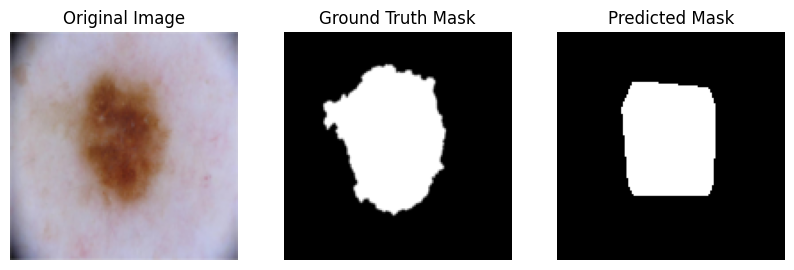

IoU:  0.7906755470980019
Dice Score:  0.920370696661892


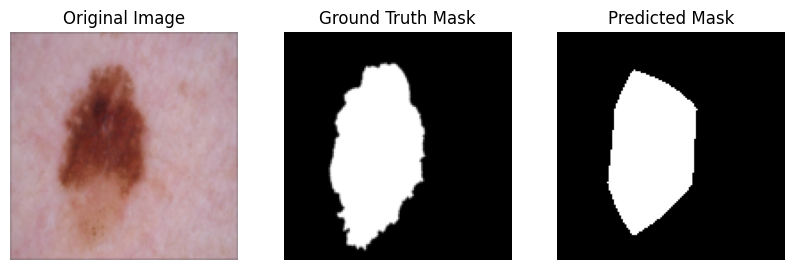

IoU:  0.6268403908794788
Dice Score:  0.7909581733958676


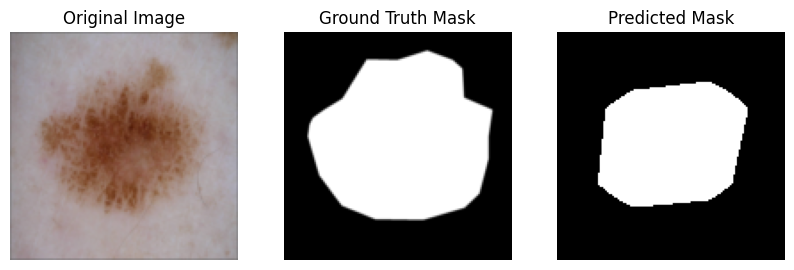

IoU:  0.8336933045356372
Dice Score:  0.9444392911400874


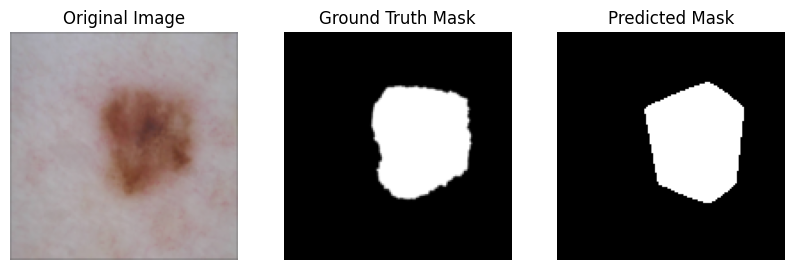

IoU:  0.7368421052631579
Dice Score:  0.8852475851881302


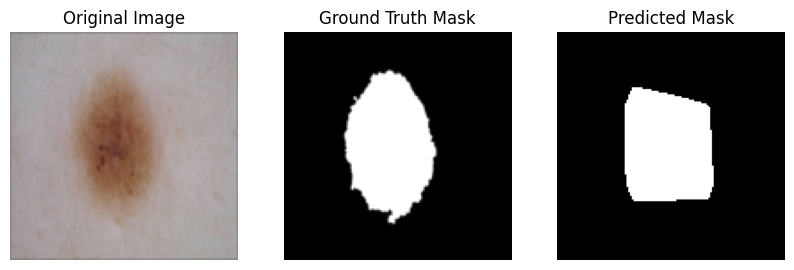

IoU:  0.8428408442669709
Dice Score:  0.9370225831199868


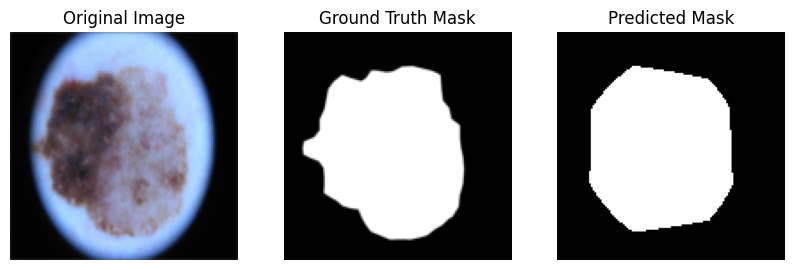

IoU:  0.7446091644204852
Dice Score:  0.8824678840790712


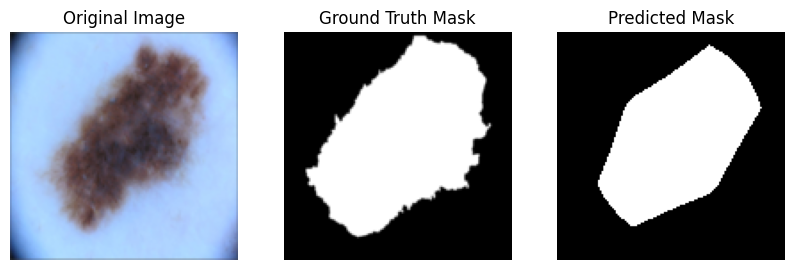

IoU:  0.8366988586479368
Dice Score:  0.9501452342084168


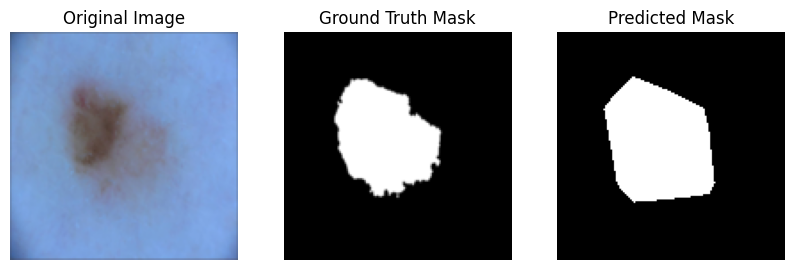

IoU:  0.8157501697216565
Dice Score:  0.920894116572845


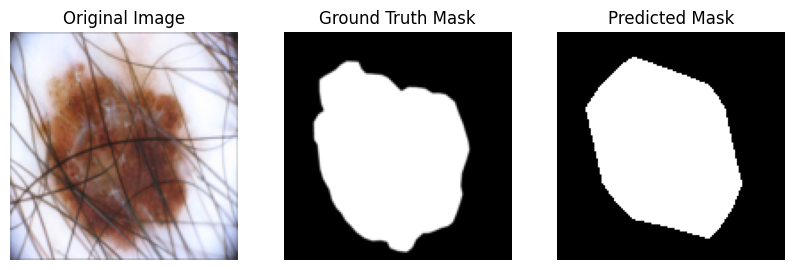

IoU:  0.8664575610683395
Dice Score:  0.9487886224856011


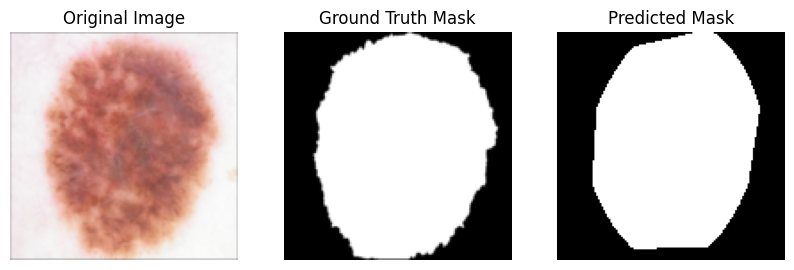

IoU:  0.8211830985915493
Dice Score:  0.9300324001038338


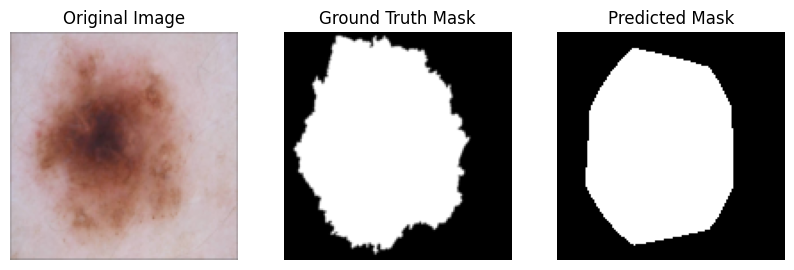

IoU:  0.8629300776914539
Dice Score:  0.954331534869309


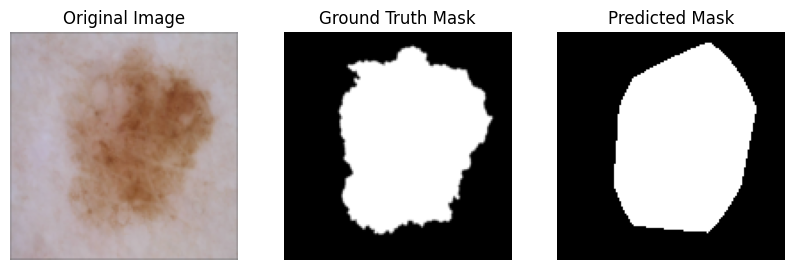

IoU:  0.7737896494156928
Dice Score:  0.9055664910277895


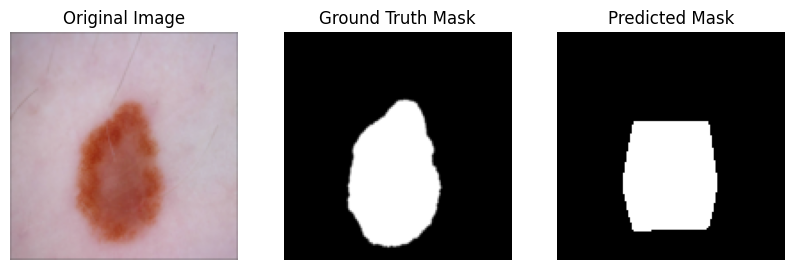

IoU:  0.8974664172759734
Dice Score:  0.9747500078904534


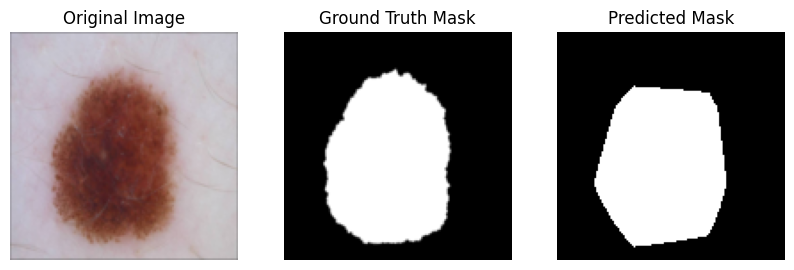

IoU:  0.7729805013927576
Dice Score:  0.895195718396323


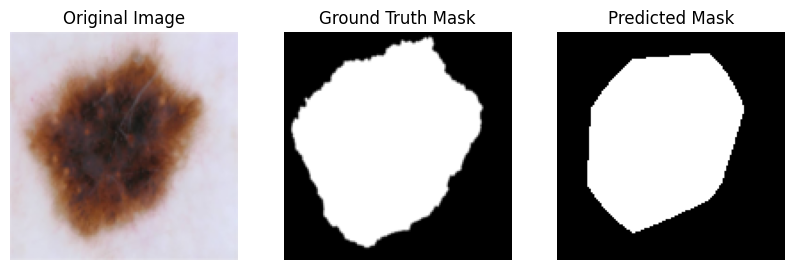

IoU:  0.7849223946784922
Dice Score:  0.9161653633544027


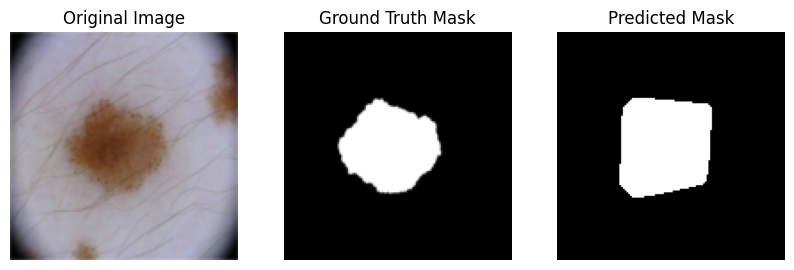

Average IoU: 0.7891907899200143
Average Dice Score: 0.9091054127303988


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model.eval()

# Initializing lists to store IoU and Dice Score values
iou_values = []
dice_scores = []

num_images_to_display = 20 # 20 images are displayed with its predicted and ground truth images

for images, gt_masks in (test_dataloader):
    images = images.to(device)
    # Pass test images through the model
    with torch.no_grad():
        outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

    # Calculating IoU and Dice Score for each pair of gt mask and predicted mask
    for image, gt_mask, predicted_mask in zip(images, gt_masks, predicted_masks):
        if num_images_to_display == 0:
            break

        image = image.permute(1, 2, 0).cpu().numpy()
        gt_mask = gt_mask.squeeze().cpu().numpy()
        predicted_mask = predicted_mask.cpu().numpy()

        # Calculating IoU
        intersection = np.logical_and(gt_mask, predicted_mask)
        union = np.logical_or(gt_mask, predicted_mask)
        iou = np.sum(intersection) / np.sum(union)
        print("IoU: ", iou)
        iou_values.append(iou)

        # Calculating Dice Score
        dice_score = 2 * np.sum(intersection) / (np.sum(gt_mask) + np.sum(predicted_mask))
        print("Dice Score: ", dice_score)
        dice_scores.append(dice_score)

        # Plot original image, gt mask, and predicted mask
        plt.figure(figsize=(10, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

        num_images_to_display -= 1

    if num_images_to_display == 0:
        break

# Calculate average IoU and Dice Score for given number of images
average_iou = np.mean(iou_values)
average_dice_score = np.mean(dice_scores)

# Printing the average IoU and Dice Score for given number of images
print("Average IoU:", average_iou)
print("Average Dice Score:", average_dice_score)


## Fine Tuning Network 2

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.upconv = nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
        self.relu = nn.ReLU()

    def forward(self, x, skip):
        x = self.relu(self.conv1(x))
        x = self.upconv(x)
        x = self.relu(self.conv2(x))
        x = self.upconv(x)
        x = self.relu(self.conv3(x))    
        # Adjusting the spatial dimensions of the skip connection tensor
        skip = nn.functional.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return x

class CustomSegmentationModel(nn.Module):
    def __init__(self, num_classes,fine_tune_encoder=False):
        super(CustomSegmentationModel, self).__init__()
        
        mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.encoder = mobilenet_v2.features

        # Freezing encoder weights if not fine-tuning
        if not fine_tune_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
        
        # Define decoder blocks
        self.decoder1 = DecoderBlock(1280, 736)
        self.decoder2 = DecoderBlock(2016, 352)
        self.decoder3 = DecoderBlock(512, 184)
        self.decoder4 = DecoderBlock(248, 128)

        # Final convolution for segmentation output
        self.last_conv = nn.Conv2d(160, num_classes, kernel_size=1)

    def forward(self, x):
        # Forward pass through the encoder
        features = []
        for name, layer in self.encoder._modules.items():
            x = layer(x)
            if name in ['4', '10', '14', '18']: 
                features.append(x)

        # Forward pass through the decoder
        x = self.decoder1(x, features[-1])
        x = self.decoder2(x, features[-2])
        x = self.decoder3(x, features[-3])
        x = self.decoder4(x, features[-4])
        x = self.last_conv(x)        
        # Upsample the output to match the size of the target masks
        x = nn.functional.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        
        return x
    
# Instantiating the model
num_classes = 2  # 2 classes considering foreground and background
model = CustomSegmentationModel(num_classes, fine_tune_encoder=True)

/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/anaconda3/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.nn.functional as F
from tqdm import tqdm

model.to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Store losses for plotting
train_losses_ce=[]
train_losses_dice=[]
train_losses_boundary=[]
train_losses_iou=[]
val_losses_ce=[]
val_losses_dice=[]
val_losses_boundary=[]
val_losses_iou=[]
num_epochs = 20
# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_ce = 0.0
    train_loss_dice = 0.0
    train_loss_boundary = 0.0
    train_loss_iou = 0.0
    for images, masks in tqdm(train_dataloader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        target_masks = masks.squeeze(1).long()
        ce_loss, dice, boundary, iou, total_loss_value = total_loss(outputs, target_masks, criterion)
        total_loss_value.backward()
        optimizer.step()
        train_loss_ce += ce_loss.item()
        train_loss_dice += dice.item()
        train_loss_boundary += boundary.item()
        train_loss_iou += iou.item()
    
    # Validation
    model.eval()
    val_loss_ce = 0.0
    val_loss_dice = 0.0
    val_loss_boundary = 0.0
    val_loss_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_dataloader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            target_masks = masks.squeeze(1).long()
            ce_loss, dice, boundary, iou, total_loss_value = total_loss(outputs, target_masks, criterion)
            val_loss_ce += ce_loss.item()
            val_loss_dice += dice.item()
            val_loss_boundary += boundary.item()
            val_loss_iou += iou.item()
    
    # Average losses
    train_loss_ce /= len(train_dataloader)
    train_loss_dice /= len(train_dataloader)
    train_loss_boundary /= len(train_dataloader)
    train_loss_iou /= len(train_dataloader)
    val_loss_ce /= len(val_dataloader)
    val_loss_dice /= len(val_dataloader)
    val_loss_boundary /= len(val_dataloader)
    val_loss_iou /= len(val_dataloader)

    # Print training and validation losses
    print(f'Epoch {epoch + 1}/{num_epochs}, Train CE Loss: {train_loss_ce:.4f}, Train Dice Loss: {train_loss_dice:.4f}, Train Boundary Loss: {train_loss_boundary:.4f}, Train IoU Loss: {train_loss_iou:.4f}, Val CE Loss: {val_loss_ce:.4f}, Val Dice Loss: {val_loss_dice:.4f}, Val Boundary Loss: {val_loss_boundary:.4f}, Val IoU Loss: {val_loss_iou:.4f}')
    
    # Store losses for plotting
    train_losses_ce.append(train_loss_ce)
    train_losses_dice.append(train_loss_dice)
    train_losses_boundary.append(train_loss_boundary)
    train_losses_iou.append(train_loss_iou)
    val_losses_ce.append(val_loss_ce)
    val_losses_dice.append(val_loss_dice)
    val_losses_boundary.append(val_loss_boundary)
    val_losses_iou.append(val_loss_iou)

  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Epoch 1/20, Train CE Loss: 0.6596, Train Dice Loss: 0.6584, Train Boundary Loss: 0.6431, Train IoU Loss: 0.7936, Val CE Loss: 0.6316, Val Dice Loss: 0.7889, Val Boundary Loss: 0.2223, Val IoU Loss: 0.8816


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 2/20, Train CE Loss: 0.3606, Train Dice Loss: 0.5128, Train Boundary Loss: 0.2660, Train IoU Loss: 0.6730, Val CE Loss: 0.3033, Val Dice Loss: 0.3951, Val Boundary Loss: 0.2249, Val IoU Loss: 0.5660


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch 3/20, Train CE Loss: 0.2331, Train Dice Loss: 0.3338, Train Boundary Loss: 0.2623, Train IoU Loss: 0.4992, Val CE Loss: 0.2040, Val Dice Loss: 0.2637, Val Boundary Loss: 0.2819, Val IoU Loss: 0.4172


100%|██████████| 6/6 [00:14<00:00,  2.37s/it]


Epoch 4/20, Train CE Loss: 0.1723, Train Dice Loss: 0.1829, Train Boundary Loss: 0.3142, Train IoU Loss: 0.3075, Val CE Loss: 0.1429, Val Dice Loss: 0.1467, Val Boundary Loss: 0.2291, Val IoU Loss: 0.2557


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 5/20, Train CE Loss: 0.1361, Train Dice Loss: 0.1216, Train Boundary Loss: 0.1379, Train IoU Loss: 0.2166, Val CE Loss: 0.1465, Val Dice Loss: 0.1147, Val Boundary Loss: 0.0855, Val IoU Loss: 0.2056


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 6/20, Train CE Loss: 0.1293, Train Dice Loss: 0.1067, Train Boundary Loss: 0.0842, Train IoU Loss: 0.1925, Val CE Loss: 0.1641, Val Dice Loss: 0.1259, Val Boundary Loss: 0.0732, Val IoU Loss: 0.2234


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch 7/20, Train CE Loss: 0.1315, Train Dice Loss: 0.1046, Train Boundary Loss: 0.0757, Train IoU Loss: 0.1891, Val CE Loss: 0.1363, Val Dice Loss: 0.1017, Val Boundary Loss: 0.0687, Val IoU Loss: 0.1845


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 8/20, Train CE Loss: 0.1109, Train Dice Loss: 0.0878, Train Boundary Loss: 0.0703, Train IoU Loss: 0.1613, Val CE Loss: 0.1480, Val Dice Loss: 0.1045, Val Boundary Loss: 0.0688, Val IoU Loss: 0.1891


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Epoch 9/20, Train CE Loss: 0.1240, Train Dice Loss: 0.0974, Train Boundary Loss: 0.0699, Train IoU Loss: 0.1770, Val CE Loss: 0.1526, Val Dice Loss: 0.1022, Val Boundary Loss: 0.0680, Val IoU Loss: 0.1854


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 10/20, Train CE Loss: 0.1120, Train Dice Loss: 0.0874, Train Boundary Loss: 0.0680, Train IoU Loss: 0.1605, Val CE Loss: 0.1501, Val Dice Loss: 0.0991, Val Boundary Loss: 0.0668, Val IoU Loss: 0.1802


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch 11/20, Train CE Loss: 0.0983, Train Dice Loss: 0.0782, Train Boundary Loss: 0.0635, Train IoU Loss: 0.1447, Val CE Loss: 0.1623, Val Dice Loss: 0.1013, Val Boundary Loss: 0.0676, Val IoU Loss: 0.1839


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 12/20, Train CE Loss: 0.0929, Train Dice Loss: 0.0758, Train Boundary Loss: 0.0627, Train IoU Loss: 0.1405, Val CE Loss: 0.1491, Val Dice Loss: 0.0951, Val Boundary Loss: 0.0657, Val IoU Loss: 0.1737


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 13/20, Train CE Loss: 0.0840, Train Dice Loss: 0.0672, Train Boundary Loss: 0.0598, Train IoU Loss: 0.1259, Val CE Loss: 0.1489, Val Dice Loss: 0.0929, Val Boundary Loss: 0.0649, Val IoU Loss: 0.1699


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 14/20, Train CE Loss: 0.0765, Train Dice Loss: 0.0643, Train Boundary Loss: 0.0583, Train IoU Loss: 0.1206, Val CE Loss: 0.1602, Val Dice Loss: 0.0939, Val Boundary Loss: 0.0652, Val IoU Loss: 0.1716


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 15/20, Train CE Loss: 0.0755, Train Dice Loss: 0.0618, Train Boundary Loss: 0.0576, Train IoU Loss: 0.1163, Val CE Loss: 0.1733, Val Dice Loss: 0.0972, Val Boundary Loss: 0.0688, Val IoU Loss: 0.1770


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 16/20, Train CE Loss: 0.0798, Train Dice Loss: 0.0658, Train Boundary Loss: 0.0590, Train IoU Loss: 0.1232, Val CE Loss: 0.1517, Val Dice Loss: 0.0920, Val Boundary Loss: 0.0653, Val IoU Loss: 0.1685


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 17/20, Train CE Loss: 0.0748, Train Dice Loss: 0.0599, Train Boundary Loss: 0.0573, Train IoU Loss: 0.1129, Val CE Loss: 0.1711, Val Dice Loss: 0.0948, Val Boundary Loss: 0.0663, Val IoU Loss: 0.1730


100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch 18/20, Train CE Loss: 0.0772, Train Dice Loss: 0.0635, Train Boundary Loss: 0.0575, Train IoU Loss: 0.1193, Val CE Loss: 0.1844, Val Dice Loss: 0.1015, Val Boundary Loss: 0.0710, Val IoU Loss: 0.1842


100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Epoch 19/20, Train CE Loss: 0.0807, Train Dice Loss: 0.0651, Train Boundary Loss: 0.0589, Train IoU Loss: 0.1221, Val CE Loss: 0.1562, Val Dice Loss: 0.0922, Val Boundary Loss: 0.0648, Val IoU Loss: 0.1687


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]

Epoch 20/20, Train CE Loss: 0.0688, Train Dice Loss: 0.0571, Train Boundary Loss: 0.0556, Train IoU Loss: 0.1079, Val CE Loss: 0.1665, Val Dice Loss: 0.0905, Val Boundary Loss: 0.0648, Val IoU Loss: 0.1659


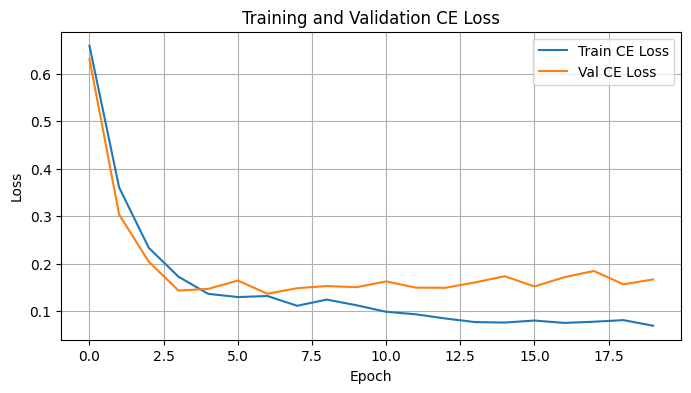

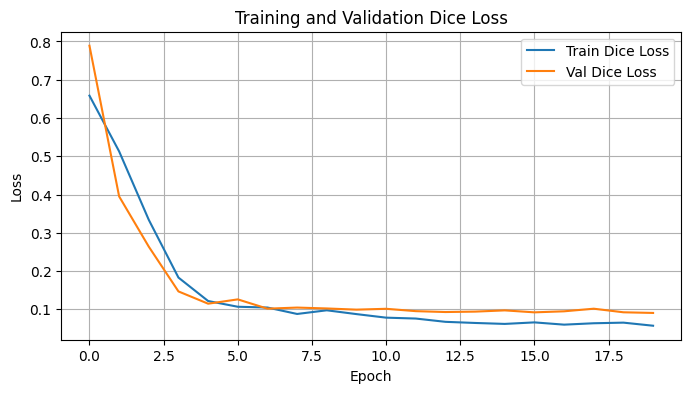

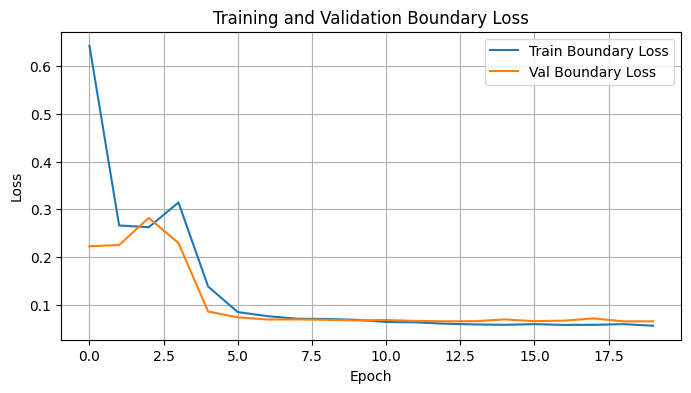

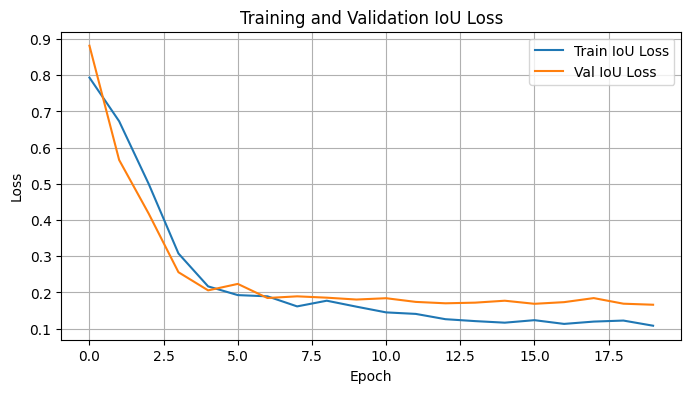

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation losses for CE Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_ce, label='Train CE Loss')
plt.plot(val_losses_ce, label='Val CE Loss')
plt.title('Training and Validation CE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for Dice Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_dice, label='Train Dice Loss')
plt.plot(val_losses_dice, label='Val Dice Loss')
plt.title('Training and Validation Dice Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for Boundary Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_boundary, label='Train Boundary Loss')
plt.plot(val_losses_boundary, label='Val Boundary Loss')
plt.title('Training and Validation Boundary Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation losses for IoU Loss
plt.figure(figsize=(8,4))
plt.plot(train_losses_iou, label='Train IoU Loss')
plt.plot(val_losses_iou, label='Val IoU Loss')
plt.title('Training and Validation IoU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Printing the average IoU and Dice Score for train and validation dataset

mean_iou, mean_dice = evaluate_segmentation_model(model, train_dataloader)

mean_iou, mean_dice = evaluate_segmentation_model(model, val_dataloader)

print(f"Train Mean IoU: {mean_iou}, Train Mean Dice Score: {mean_dice}")
print(f"Validation Mean IoU: {mean_iou}, Validation Mean Dice Score: {mean_dice}")

100%|██████████| 6/6 [00:13<00:00,  2.28s/it]

Train Mean IoU: 0.7973749960272088, Train Mean Dice Score: 0.9186309581328834
Validation Mean IoU: 0.7973749960272088, Validation Mean Dice Score: 0.9186309581328834


In [ ]:
# Printing the average IoU and Dice Score for whole test dataset

mean_iou, mean_dice = evaluate_segmentation_model(model, test_dataloader)
print(f"Test Mean IoU: {mean_iou}, Test Mean Dice Score: {mean_dice}")

100%|██████████| 12/12 [00:26<00:00,  2.17s/it]

Test Mean IoU: 0.7928388439143482, Test Mean Dice Score: 0.9127378031105571


IoU:  0.9311245307654643
Dice Score:  0.9904311545555752


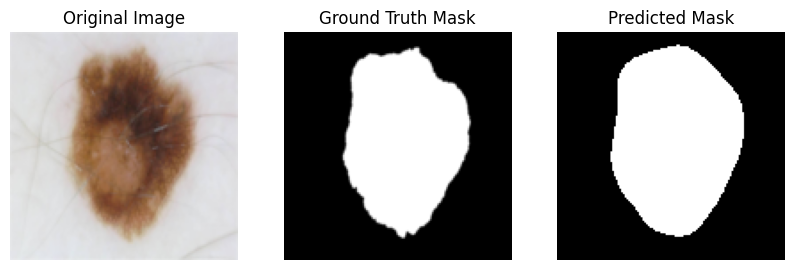

IoU:  0.9044117647058824
Dice Score:  1.0154076581355849


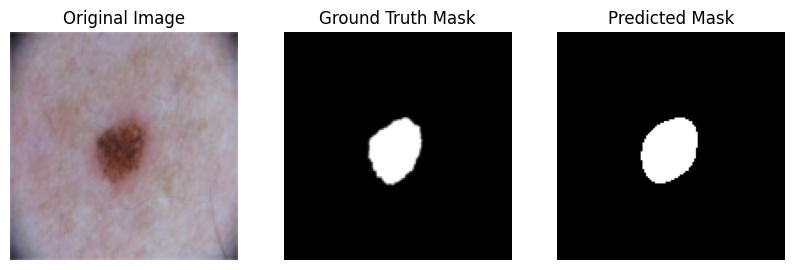

IoU:  0.8684701492537313
Dice Score:  0.9608037402898442


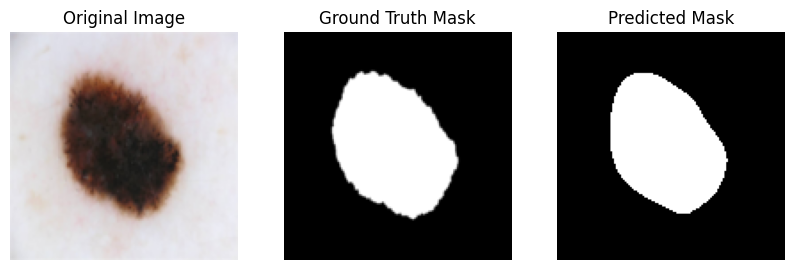

IoU:  0.9382667194301544
Dice Score:  0.9997903980912637


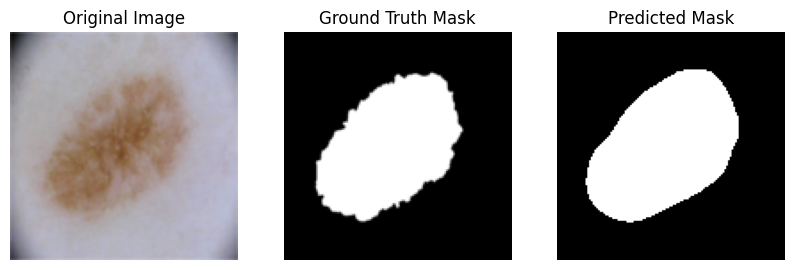

IoU:  0.7771113243761996
Dice Score:  0.9120462521526018


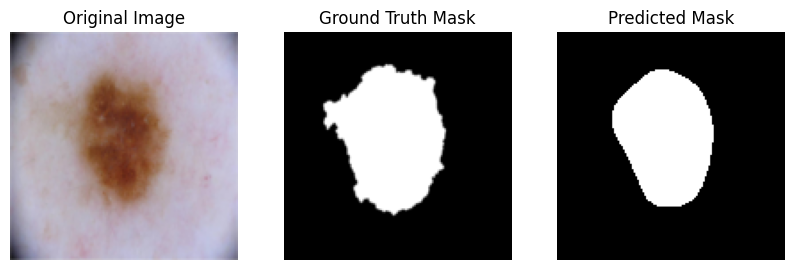

IoU:  0.7727491574386134
Dice Score:  0.909454521723044


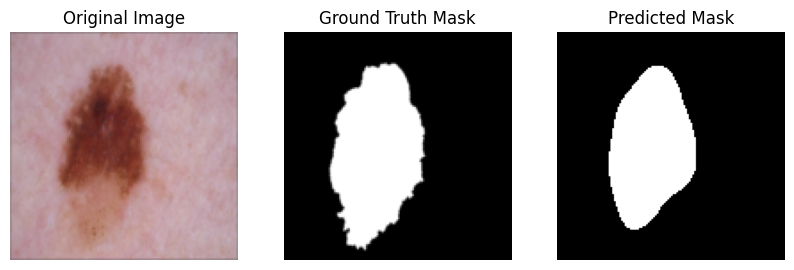

IoU:  0.7768078175895765
Dice Score:  0.8954646287036205


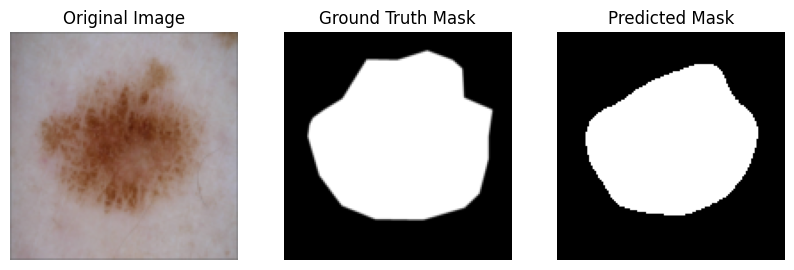

IoU:  0.8694668820678514
Dice Score:  0.9671309227395452


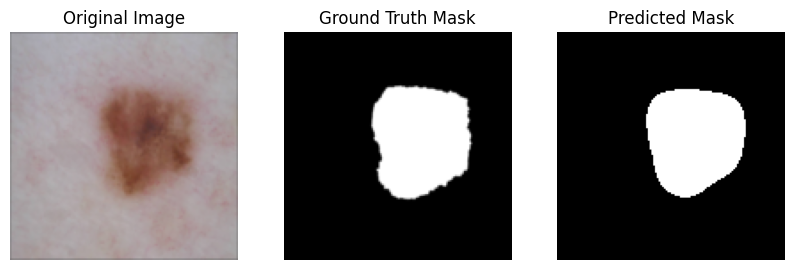

IoU:  0.8955448524984949
Dice Score:  0.9849803749191482


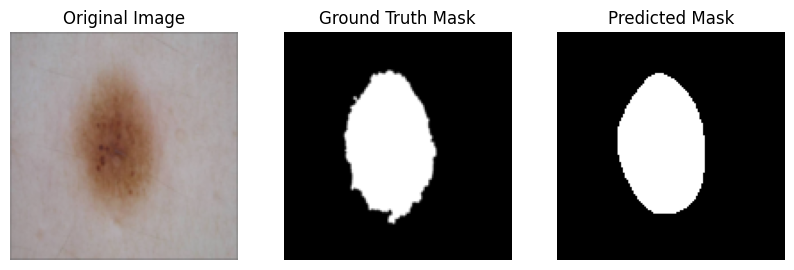

IoU:  0.8443528199087027
Dice Score:  0.9386594229137082


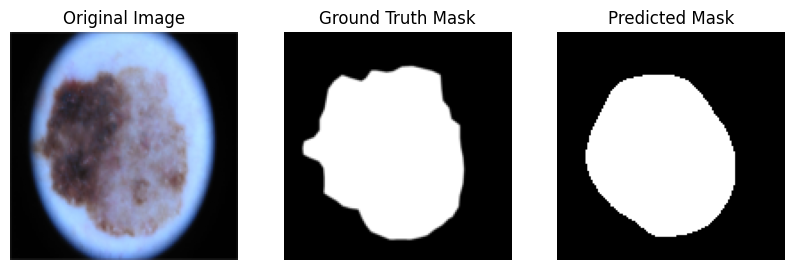

IoU:  0.8673729381788923
Dice Score:  0.9581014199381545


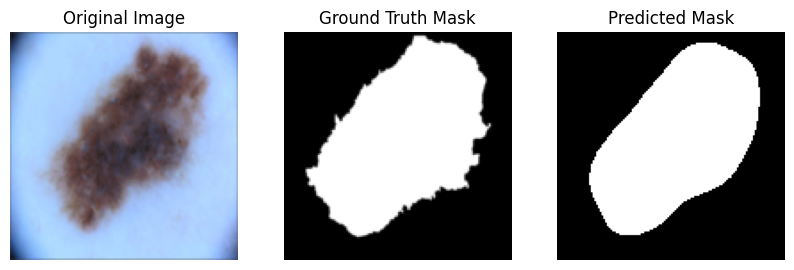

IoU:  0.6703929539295393
Dice Score:  0.8469884100493608


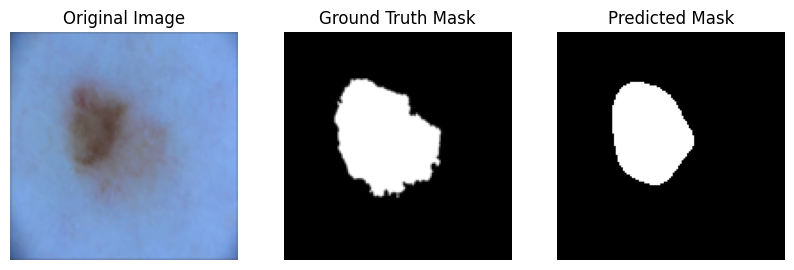

IoU:  0.8861038961038961
Dice Score:  0.9611085261000712


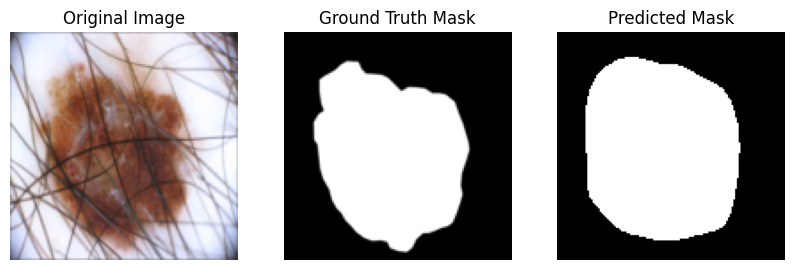

IoU:  0.9321759038443194
Dice Score:  0.9853745673334942


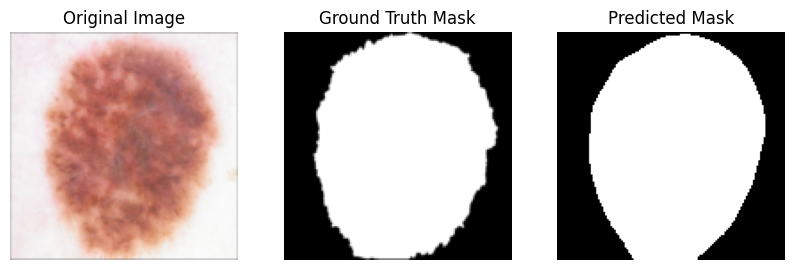

IoU:  0.8988253546099291
Dice Score:  0.9746120081140377


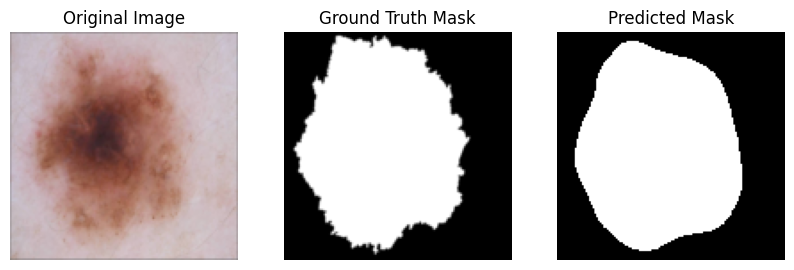

IoU:  0.9169329073482428
Dice Score:  0.9846872814287777


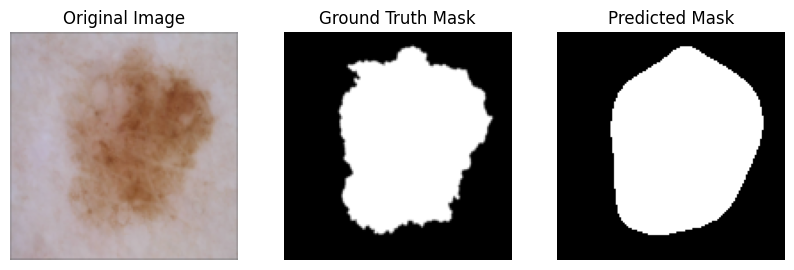

IoU:  0.8996228604583696
Dice Score:  0.9821042741038065


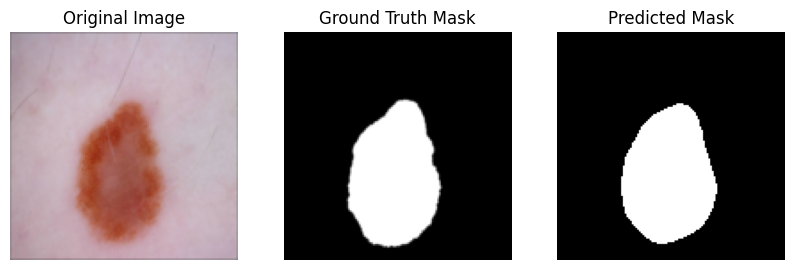

IoU:  0.9412972787951395
Dice Score:  0.9987793681833795


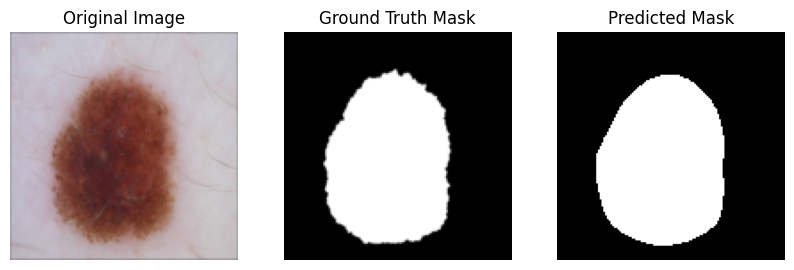

IoU:  0.8535224366426413
Dice Score:  0.9444649141242842


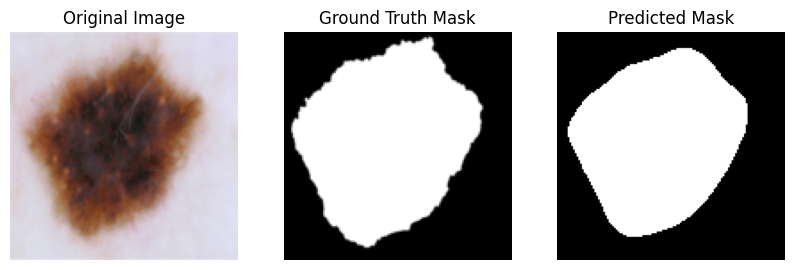

IoU:  0.9105725031341413
Dice Score:  0.9952685851146462


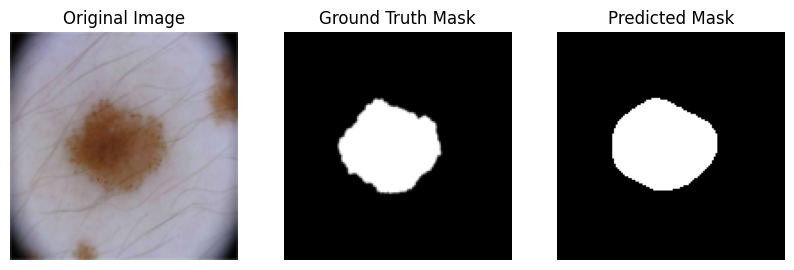

Average IoU: 0.867756252553989
Average Dice Score: 0.9602829214356975


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model.eval()

# Initializing lists to store IoU and Dice Score values
iou_values = []
dice_scores = []

num_images_to_display = 20 # 20 images are displayed with its predicted and ground truth images

for images, gt_masks in (test_dataloader):
    images = images.to(device)
    # Pass test images through the model
    with torch.no_grad():
        outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

    # Calculating IoU and Dice Score for each pair of gt mask and predicted mask
    for image, gt_mask, predicted_mask in zip(images, gt_masks, predicted_masks):
        if num_images_to_display == 0:
            break

        image = image.permute(1, 2, 0).cpu().numpy()
        gt_mask = gt_mask.squeeze().cpu().numpy()
        predicted_mask = predicted_mask.cpu().numpy()

        # Calculating IoU
        intersection = np.logical_and(gt_mask, predicted_mask)
        union = np.logical_or(gt_mask, predicted_mask)
        iou = np.sum(intersection) / np.sum(union)
        print("IoU: ", iou)
        iou_values.append(iou)

        # Calculating Dice Score
        dice_score = 2 * np.sum(intersection) / (np.sum(gt_mask) + np.sum(predicted_mask))
        print("Dice Score: ", dice_score)
        dice_scores.append(dice_score)

        # Plot original image, gt mask, and predicted mask
        plt.figure(figsize=(10, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

        num_images_to_display -= 1

    if num_images_to_display == 0:
        break

# Calculate average IoU and Dice Score for given number of images
average_iou = np.mean(iou_values)
average_dice_score = np.mean(dice_scores)

# Printing the average IoU and Dice Score for given number of images
print("Average IoU:", average_iou)
print("Average Dice Score:", average_dice_score)


## Data Augmentation Tried

Below is the data Augmentation and normalization i tried it did not outperfrom above approach so i have dropped it

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
    transforms.RandomRotation(30),      # Randomly rotate the image by up to 30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Adjust brightness, contrast, saturation, and hue randomly
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image with ImageNet mean and standard deviation
])

# Define a separate transformation for the mask images
mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mask_transform = mask_transform
        if train:
            self.image_folder = os.path.join(root_dir, 'train')
            self.mask_folder = os.path.join(root_dir, 'train_masks')
        else:
            self.image_folder = os.path.join(root_dir, 'test')
            self.mask_folder = os.path.join(root_dir, 'test_masks')

        self.image_files = sorted(os.listdir(self.image_folder))
        self.mask_files = sorted(os.listdir(self.mask_folder))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        mask_name = os.path.join(self.mask_folder, self.mask_files[idx])

        image = Image.open(img_name).convert('RGB')
        mask = Image.open(mask_name).convert('L')  # Convert mask to grayscale

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

root_dir = 'data'
# Creating custom dataset for the entire dataset
full_dataset = CustomDataset(root_dir=root_dir, train=True, transform=transform, mask_transform=mask_transform)


# Splitting dataset into train, validation, and test sets
train_size = int(0.6 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# Creating data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
